In [2]:
# general packages
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os 
import json
import itertools
import random

# specific packages
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.pyplot import xticks
from scipy.optimize import curve_fit
from polyfit import load_example, PolynomRegressor, Constraints
import matplotlib.ticker as tck
from sklearn.metrics import mean_squared_error
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


# set style
#sns.set_style("white")

# Cell doublet

In [3]:
# set working directory
os.chdir("C:\\Users\\anr9744\\Projects\\Goo\\data")
"C:\\tmp\\sorting_test_rendering"

'C:\\tmp\\sorting_test_rendering'

In [4]:
# load data
with open(f"doublet_polyplot.json", 'r') as f:
    master_dict = json.load(f)

enum = list(range(len(master_dict["Distances"])))
times_tmp = master_dict['Times']
times = [[time / 1000000 for time in times_tmp[i]] for i in enum]
distances = master_dict['Distances']
frames = master_dict['Frames']

len(distances[0])

FileNotFoundError: [Errno 2] No such file or directory: 'doublet_polyplot.json'

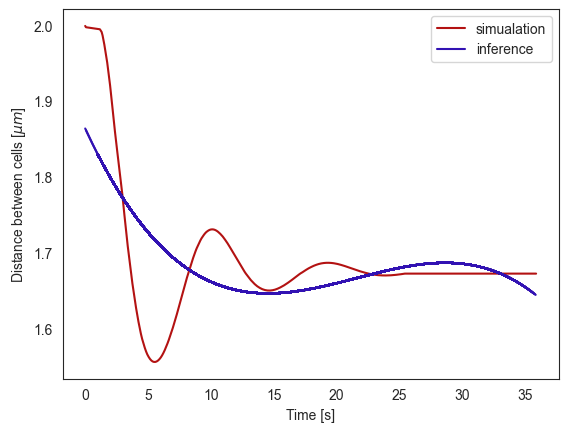

In [ ]:
fig, ax = plt.subplots()

df = pd.DataFrame({'x': times[0],
                   'y': distances[0]})

# fit a polynomial curve on data
poly3 = np.poly1d(np.polyfit(df.x, df.y, deg = 3))
polyline = np.linspace(1, df.x[:-1], 500)


# compute colors
hsv2rgb = lambda hue: mcolors.hsv_to_rgb([hue,0.9,0.7])
hues = np.linspace(0, 0.7, len([0,1]))
colors = [hsv2rgb(hue) for hue in hues]

# plot
ax.plot(df.x, df.y, color=colors[0])
ax.plot(polyline, poly3(polyline), '-', color=colors[1])

# labels and legend
plt.ylabel(r'Distance between cells [$\mu m$]')
plt.xlabel(r'Time [s]')
#plt.legend(title = r'$falloff\_power = 0;   strength = -1000$')
plt.legend(['simualation', 'inference'])
ax.grid(False)
locs, labels = xticks()

# plot save to data foler
plt.savefig(f"doublet_fit.png", dpi=500)

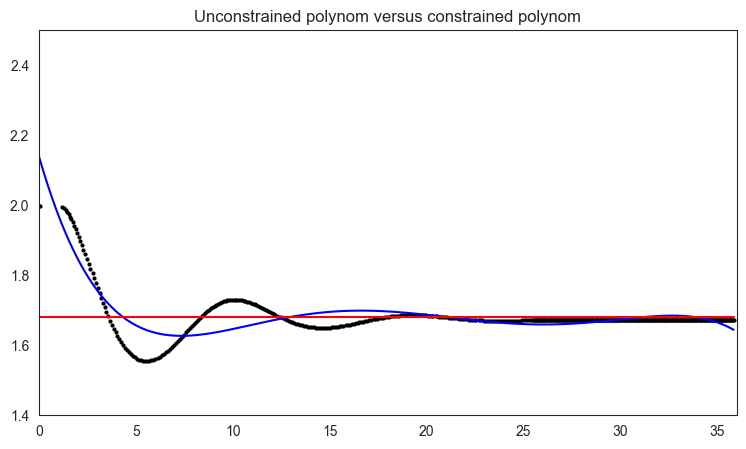

In [ ]:
X, y = np.array(times[0]), np.array(distances[0])
x_plot = np.linspace(0, np.amax(X), 500)

X = X.reshape((-1,1))

DEG = 5

np_coeffs = np.polyfit(X.ravel(), y, DEG)
polyestimator = PolynomRegressor(deg=DEG)
vander = np.vander(x_plot, N = DEG +1)
pred_numpy = vander@np_coeffs

polyestimator = PolynomRegressor(deg=DEG)
monotone_constraint = Constraints(monotonicity='inc')
polyestimator.fit(X, y, loss = 'l2', constraints={0: monotone_constraint})
pred_mon = polyestimator.predict(x_plot.reshape(-1, 1))

f, ax = plt.subplots(1, figsize = (9, 5))
ax.set_xlim(0, 36)
ax.set_ylim(1.4, 2.5)
ax.set_title("Unconstrained polynom versus constrained polynom")
ax.scatter(X, y, c='k', s=4)

ax.plot(x_plot, pred_numpy, c='b', label='Degree=3 Unconstrained')
ax.plot(x_plot, pred_mon, c='r', label='Degree=3 Monotonic')

IndexError: list index out of range

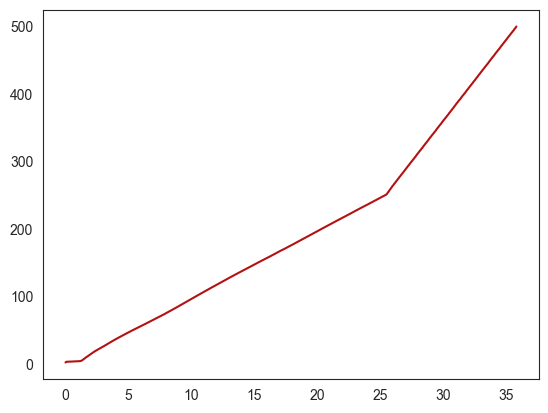

In [ ]:
fig, ax = plt.subplots()

df = pd.DataFrame({'x': times[0],
                   'y': frames[0]})

# fit a polynomial curve on data
poly3 = np.poly1d(np.polyfit(df.x, df.y, deg = 10))
polyline = np.linspace(1, df.x[:-1], 500)


# compute colors
hsv2rgb = lambda hue: mcolors.hsv_to_rgb([hue,0.9,0.7])
hues = np.linspace(0, 0.7, len(enum))
colors = [hsv2rgb(hue) for hue in hues]

# plot
ax.plot(df.x, df.y, color=colors[0])
ax.plot(polyline, poly3(polyline), '--', color=colors[1])

# labels and legend
plt.ylabel(r'frames')
plt.xlabel(r'time [s]')
#plt.legend(title = r'$falloff\_power = 0;   strength = -1000$')
plt.legend(['simulation', 'inference'])
ax.grid(False)
locs, labels = xticks()

# plot save to data foler
#plt.savefig(f"doublet_fit.png", dpi=500)
#plt.plot(times[0], frames[0], "-")

A = 0.424762869999274
w = 0.6699785990110304
phi = -0.8305179147014226
c = 4.754169482728897
k = 1.6740356019796734


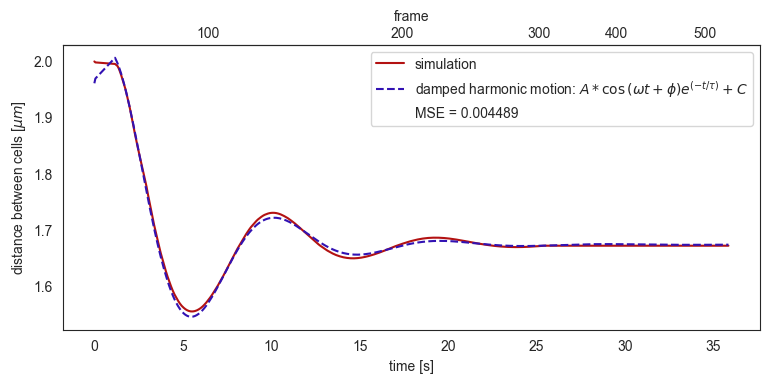

In [ ]:
### mapping from time to frame
df = pd.DataFrame({'x': times[0], 'y': frames[0]})
# fit a polynomial curve on forward data
poly3_forward = np.poly1d(np.polyfit(df.x, df.y, deg = 5))
# fit a polynomial curve on reverse data
poly3_reverse = np.poly1d(np.polyfit(df.y, df.x, deg = 5))

### fitting hyperbola to simulation data
def polynomial(df, deg):
    # fit a polynomial curve on data
    poly3 = np.poly1d(np.polyfit(df.x, df.y, deg = deg))

    return poly3, polyline

def hyperbola(a, b, x):
    return a*0.3 / x + b*1.66

def damped_harmonic_motion(t, A, omega, phi, tau, C):
    return A * np.exp(-t/tau) * np.cos(omega*t + phi) + C

x, y = np.array(times[0]), np.array(distances[0])
t = np.linspace(1, x[:-1], 500)

# compute colors
hsv2rgb = lambda hue: mcolors.hsv_to_rgb([hue,0.9,0.7])
hues = np.linspace(0, 0.7, len([0,1]))
colors = [hsv2rgb(hue) for hue in hues]

# plot
f, ax1 = plt.subplots(1, figsize = (9, 3.7))

# Use the curve_fit function to fit the hyperbolic curve
popt, pcov = curve_fit(damped_harmonic_motion, x, y)

# Compute the root-mean-square error (RMSE)
y_fit = damped_harmonic_motion(x, *popt)
rmse = np.sqrt(np.mean((y - y_fit)**2))

# Print the fitted parameter values
print('A =', popt[0])
print('w =', popt[1])
print('phi =', popt[2])
print('c =', popt[3])
print('k =', popt[4])

ax1.plot(x, y, color = colors[0], label = 'simulation')
ax1.plot(x, damped_harmonic_motion(x, *popt), '--', color = colors[1], label =  r'damped harmonic motion: ${A} * \cos{{(\omega t + \phi)}} e^{{(-t/\tau)}} + C$')
# Create empty plot with blank marker containing the extra label
ax1.plot([], [], ' ', label=f'MSE = {rmse:.6f}')

# layout
plt.setp(ax1.get_xticklabels(), visible=True)
ax2 = ax1.secondary_xaxis('top', functions=(poly3_forward, poly3_reverse))
ax2.set_xlabel(r'frame')
#plt.setp(ax2.get_xticklabels(), visible=True)
ax2.tick_params(axis='both', which='both', length=0)

plt.ylabel(r'distance between cells [$\mu m$]')
plt.xlabel(r'time [s]')
#plt.legend(['simulation', r'${A} * \cos{{(\omega t + \phi)}} e^{{(-t/\tau)}} + C$'])
plt.legend()


plt.savefig(f"doublet_hyperbola.png", dpi=500)
plt.savefig(f"doublet_fit.png", dpi=500)
plt.show()

# Sorting score

In [6]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX3080seed1")

# load data
with open(f"data1.json", 'r') as f1:
    data1 = json.load(f1)

with open(f"data1_time.json", 'r') as f2:
    times1 = json.load(f2)
    times1 = [float(time) / 60 for time in list(times1.values())]


In [7]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX4090seed1")

# load data
with open(f"RTX4090_data1.json", 'r') as f1:
    data2 = json.load(f1)

with open(f"RTX4090_data1_time.json", 'r') as f2:
    times2 = json.load(f2)
    times2 = [float(time) / 60 for time in list(times2.values())]


In [8]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX3080seed2")

# load data
with open(f"data2.json", 'r') as f1:
    data3 = json.load(f1)

with open(f"data2_time.json", 'r') as f2:
    times3 = json.load(f2)
    times3 = [float(time) / 60 for time in list(times3.values())]

In [9]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX3080seed4")

# load data
with open(f"data4.json", 'r') as f1:
    data4 = json.load(f1)

with open(f"data4_time.json", 'r') as f2:
    times4 = json.load(f2)
    times4 = [float(time) / 60 for time in list(times4.values())]

In [10]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX4090seed3")

# load data
with open(f"data3.json", 'r') as f1:
    data5 = json.load(f1)

with open(f"data3_time.json", 'r') as f2:
    times5 = json.load(f2)
    times5 = [float(time) / 60 for time in list(times5.values())]

In [11]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX3080motion250")

# load data
with open(f"data1.json", 'r') as f1:
    data6 = json.load(f1)

with open(f"data1_time.json", 'r') as f2:
    times6 = json.load(f2)
    times6 = [float(time) / 60 for time in list(times6.values())]

In [12]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX4090seed5")

# load data
with open(f"data5.json", 'r') as f1:
    data7 = json.load(f1)

with open(f"data5_time.json", 'r') as f2:
    times7 = json.load(f2)
    times7 = [float(time) / 60 for time in list(times7.values())]

In [13]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX3080motion250seed2")

# load data
with open(f"data2.json", 'r') as f1:
    data8 = json.load(f1)

with open(f"data2_time.json", 'r') as f2:
    times8 = json.load(f2)
    times8 = [float(time) / 60 for time in list(times8.values())]

In [14]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX3080motion250seed3")

# load data
with open(f"RTX3080motion250seed3.json", 'r') as f1:
    data9 = json.load(f1)

with open(f"RTX3080motion250seed3_time.json", 'r') as f2:
    times9 = json.load(f2)
    times9 = [float(time) / 60 for time in list(times9.values())]

In [15]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX3080motion250seed4")

# load data
with open(f"data4.json", 'r') as f1:
    data10 = json.load(f1)

with open(f"data4_time.json", 'r') as f2:
    times10 = json.load(f2)
    times10 = [float(time) / 60 for time in list(times10.values())]

In [16]:
# set working directory
os.chdir("C:\\tmp\\adhesion-based-sorting\\RTX3080motion250seed5")

# load data
with open(f"data5.json", 'r') as f1:
    data11 = json.load(f1)

with open(f"data5_time.json", 'r') as f2:
    times11 = json.load(f2)
    times11 = [float(time) / 60 for time in list(times11.values())]

In [21]:
frames = [int(frame) for frame in list(data1.keys())]
values1_cellsB = [data1[frame]["A_Cells"] for frame in data1]
values1_cellsA = [data1[frame]["B_Cells"] for frame in data1]

frames2 = [int(frame) for frame in list(data2.keys())]
values2_cellsB = [data2[frame]["A_Cells"] for frame in data2]
values2_cellsA = [data2[frame]["B_Cells"] for frame in data2]

frames3 = [int(frame) for frame in list(data3.keys())]
values3_cellsB = [data3[frame]["A_Cells"] for frame in data3]
values3_cellsA = [data3[frame]["B_Cells"] for frame in data3]

frames4 = [int(frame) for frame in list(data4.keys())]
values4_cellsB = [data4[frame]["A_Cells"] for frame in data4]
values4_cellsA = [data4[frame]["B_Cells"] for frame in data4]

frames5 = [int(frame) for frame in list(data5.keys())]
values5_cellsB = [data5[frame]["A_Cells"] for frame in data5]
values5_cellsA = [data5[frame]["B_Cells"] for frame in data5]

frames6 = [int(frame) for frame in list(data6.keys())]
values6_cellsB = [data6[frame]["A_Cells"] for frame in data6]
values6_cellsA = [data6[frame]["B_Cells"] for frame in data6]

frames7 = [int(frame) for frame in list(data7.keys())]
values7_cellsB = [data7[frame]["A_Cells"] for frame in data7]
values7_cellsA = [data7[frame]["B_Cells"] for frame in data7]

frames8 = [int(frame) for frame in list(data8.keys())]
values8_cellsB = [data8[frame]["A_Cells"] for frame in data8]
values8_cellsA = [data8[frame]["B_Cells"] for frame in data8]

frames9 = [int(frame) for frame in list(data9.keys())]
values9_cellsB = [data9[frame]["A_Cells"] for frame in data9]
values9_cellsA = [data9[frame]["B_Cells"] for frame in data9]

frames10 = [int(frame) for frame in list(data10.keys())]
values10_cellsB = [data10[frame]["A_Cells"] for frame in data10]
values10_cellsA = [data10[frame]["B_Cells"] for frame in data10]

frames11 = [int(frame) for frame in list(data11.keys())]
values11_cellsB = [data11[frame]["A_Cells"] for frame in data11]
values11_cellsA = [data11[frame]["B_Cells"] for frame in data11]

498
498
498
498
82.04165545000001
81.74757711666666
93.11912838333333


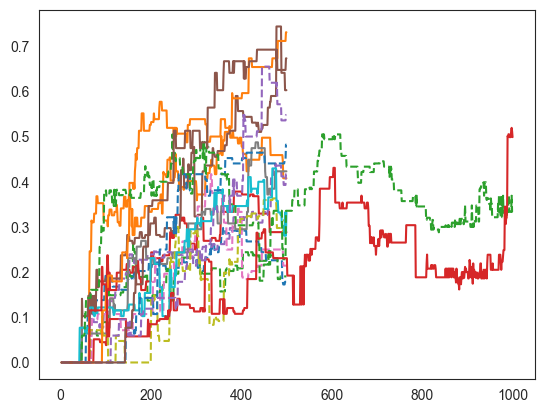

In [22]:

print(len(values1_cellsA))
print(len(values1_cellsB))
print(len(frames1))
print(len(times1))
print(times2[-1])
print(times5[-1])
print(times7[498])

plt.plot(frames1, values1_cellsA, '--')
plt.plot(frames1, values1_cellsB)

plt.plot(frames2, values2_cellsA, '--')
plt.plot(frames2, values2_cellsB)

plt.plot(frames3, values3_cellsA, '--')
plt.plot(frames3, values3_cellsB)

plt.plot(frames4, values4_cellsA, '--')
plt.plot(frames4, values4_cellsB)

plt.plot(frames5, values5_cellsA, '--')
plt.plot(frames5, values5_cellsB)

plt.plot(frames6, values6_cellsA, '--')
plt.plot(frames6, values6_cellsB)

plt.plot(frames7, values7_cellsA, '--')
plt.plot(frames7, values7_cellsB)

plt.plot(frames8, values8_cellsA, '--')
plt.plot(frames8, values8_cellsB)

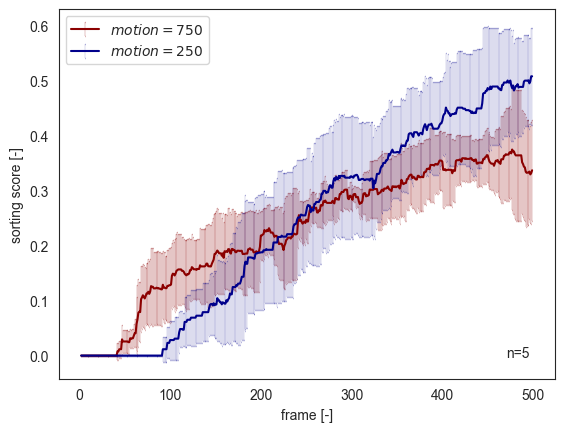

In [52]:
# random motion = -750
averages1 = [sum(items) / len(items) for items in zip(*[values1_cellsA, values1_cellsB])]
averages2 = [sum(items) / len(items) for items in zip(*[values2_cellsA, values2_cellsB])]
averages3 = [sum(items) / len(items) for items in zip(*[values3_cellsA, values3_cellsB])]
averages4 = [sum(items) / len(items) for items in zip(*[values4_cellsA, values4_cellsB])]
averages5 = [sum(items) / len(items) for items in zip(*[values5_cellsA, values5_cellsB])]
# Calculate mean and standard deviation
mean_values = np.mean([averages1, averages2, averages3, averages4, averages5], axis=0)
std_values = np.std([averages1, averages2, averages3, averages4, averages5], axis=0)

# random motion = -250
averages6 = [sum(items) / len(items) for items in zip(*[values6_cellsA, values6_cellsB])]
averages8 = [sum(items) / len(items) for items in zip(*[values8_cellsA, values8_cellsB])]
averages9 = [sum(items) / len(items) for items in zip(*[values9_cellsA, values9_cellsB])]
averages10 = [sum(items) / len(items) for items in zip(*[values10_cellsA, values10_cellsB])]
averages11 = [sum(items) / len(items) for items in zip(*[values11_cellsA, values11_cellsB])]

# Calculate mean and standard deviation
mean_values250 = np.mean([averages6, averages8, averages9, averages10, averages11], axis=0)
std_values250 = np.std([averages6, averages8, averages9, averages10, averages11], axis=0)

# Normalize mean and standard deviation
normalized_mean = (mean_values - np.min(mean_values)) / (np.max(mean_values) - np.min(mean_values))
normalized_std = std_values / (np.max(mean_values) - np.min(mean_values))

#normalized_std = np.minimum(normalized_std, 1.0)

# Plot mean with standard deviation
plt.errorbar(frames, mean_values, yerr=std_values, fmt='-', 
             color = 'darkred', ecolor = 'darkred', 
             capsize = 0.1, elinewidth = 0.17, capthick = 1,  
             label='n=5')

plt.errorbar(frames, mean_values250, yerr=std_values250, fmt='-', 
             color = 'darkblue', ecolor = 'darkblue', 
             capsize = 0.1, elinewidth = 0.1, capthick = 1,  
             label='n=5')

#plt.plot(frames6, averages6)

# labels and legend
plt.ylabel(r'sorting score [-]')
plt.xlabel(r'frame [-]')
#plt.legend(title = r'$falloff\_power = 0;   strength = -1000$')
plt.legend([r'$motion = 750$', r'$motion = 250$', r'n=5'])
plt.text(0.95, 0.05, r'n=5', ha='right', va='bottom', transform=plt.gca().transAxes)
locs, labels = xticks()

# plot save to data foler
plt.savefig(f"sorting_score.png", transparent = False, dpi=500)

# MSD

In [212]:
# set working directory
os.chdir("C:\\tmp\\differential_motion\\new")


directory = "C:\\tmp\\differential_motion\\new"  # Replace with the actual directory path

msd_dicts = []
msd_vars = []
msd_files = []

for index, filename in enumerate(os.listdir(directory)):
    if filename.endswith("msd.json"):
        msd_files.append(filename)

for index, filename in enumerate(msd_files):
    file_path = os.path.join(directory, filename)
    with open(file_path, 'r') as f:
        msd_data = json.load(f)
        globals()["msd" + str(index)] = msd_data
        msd_dicts.append(globals()["msd" + str(index)])
        msd_vars.append("msd" + str(index))
print(msd_vars)


'''with open(f"data2_new_msd.json", 'r') as f6:
    msd6 = json.load(f6)

with open(f"data3_new_msd.json", 'r') as f6:
    msd7 = json.load(f6)

with open(f"data4_new_msd.json", 'r') as f6:
    msd8 = json.load(f6)

with open(f"data5_new_msd.json", 'r') as f6:
    msd9 = json.load(f6)

with open(f"data6_new_msd.json", 'r') as f6:
    msd10 = json.load(f6)'''



['msd0', 'msd1', 'msd2', 'msd3', 'msd4', 'msd5', 'msd6', 'msd7', 'msd8', 'msd9', 'msd10', 'msd11', 'msd12', 'msd13', 'msd14', 'msd15', 'msd16', 'msd17', 'msd18', 'msd19', 'msd20', 'msd21', 'msd22', 'msd23', 'msd24', 'msd25', 'msd26', 'msd27', 'msd28', 'msd29']


'with open(f"data2_new_msd.json", \'r\') as f6:\n    msd6 = json.load(f6)\n\nwith open(f"data3_new_msd.json", \'r\') as f6:\n    msd7 = json.load(f6)\n\nwith open(f"data4_new_msd.json", \'r\') as f6:\n    msd8 = json.load(f6)\n\nwith open(f"data5_new_msd.json", \'r\') as f6:\n    msd9 = json.load(f6)\n\nwith open(f"data6_new_msd.json", \'r\') as f6:\n    msd10 = json.load(f6)'

{'cell_A1_tracks': [8.356459310721457e-09, 1.624396108434666e-08, 1.179566270320355e-08, 1.7893477866842682e-08, 1.1381193098437222e-08, 7.84612692812506e-09, 1.5991699801322323e-08, 3.876326807441364e-08, 3.339566255939074e-08, 7.401909192798452e-08, 3.814112324557503e-08, 1.2392576388186504e-07, 5.980022599134272e-08, 5.6874311620693945e-08, 2.7965512200247053e-08, 6.415187181045457e-08, 5.926808653796391e-08, 5.798416501323669e-07, 5.750763405693506e-07, 1.3286225354832623e-08, 4.447436217416593e-08, 2.2753652443412634e-08, 4.322979750565325e-08, 1.1519455446405869e-07, 3.870127035015141e-07, 4.506995205333813e-07, 6.544087431290477e-08, 8.896316461544469e-08, 2.4818221728126633e-08, 9.348210774188166e-09, 4.8670319752177484e-08, 3.470036518515186e-08, 2.038737990315207e-07, 6.887803932785395e-08, 6.748706232286846e-08, 4.4716338372962844e-08, 1.2672413916354276e-08, 1.0489773920773763e-08, 3.9502735102480006e-08, 4.5062242193300576e-08, 1.4464386112641226e-07, 9.215575849263042e-08

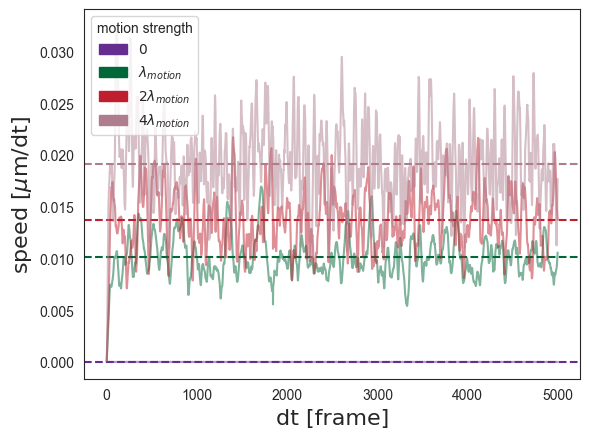

In [253]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch

import os
os.chdir("C:\\tmp\\differential_motion\\")

with open(f"data_test_speed10_speed.json", 'r') as f6:
    speed1 = json.load(f6)
with open(f"data_test_speed20_speed.json", 'r') as f6:
    speed2 = json.load(f6)
with open(f"data_test_speed30_speed.json", 'r') as f6:
    speed3 = json.load(f6)
with open(f"data_test_speed40_speed.json", 'r') as f6:
    speed4 = json.load(f6)
with open(f"data_test_speed50_speed.json", 'r') as f6:
    speed5 = json.load(f6)

merged_dict = {}
for key in speed1:
    merged_dict[key] = [(speed1[key][i] + speed2[key][i] + speed3[key][i] + speed4[key][i] + speed5[key][i]) / 5 for i in range(len(speed1[key]))]

print(merged_dict)

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']

# Create a list to store legend handles
legend_handles = []

# Define the legend labels
legend_labels = [r'$0$', r'$\lambda_{motion}$', r'2$\lambda_{motion}$', r'4$\lambda_{motion}$']

# Create a list to store mean speeds
mean_speeds = []

# Plot each track
for idx, (key, values) in enumerate(merged_dict.items()):
    # Get the color based on the index in the color palette
    color = color_palette[idx % len(color_palette)]

    plt.plot(values, color=color, alpha=0.5)

    # Calculate the mean of the track
    track_mean = np.mean(values)

    # Create a legend handle with the plot
    legend_handle = Patch(color=color, label=legend_labels[idx])
    legend_handles.append(legend_handle)

    # Plot the mean as a horizontal line
    plt.axhline(track_mean, color=color, linestyle='--')

# Set the font properties for the legend
legend_font_props = {'family': 'Myriad Pro', 'size': 10}
plt.legend(handles=legend_handles, title='motion strength', prop=legend_font_props)

# Set the font properties for the axis labels
axis_label_font_props = {'family': 'Myriad Pro', 'size': 16}
plt.xlabel(r'dt [frame]', fontdict=axis_label_font_props)
plt.ylabel(r'speed [$\mu$m/dt]', fontdict=axis_label_font_props)

# Save the plot to the data folder
plt.savefig(f"speed.png", transparent=False, dpi=500)

# Display the plot
plt.show()


{'cell_A1_tracks': [8.470010044341756e-17, 5.461809997659593e-16, 5.810252442320325e-16, 1.4266172398814152e-16, 1.3760723522145455e-17, 6.183828245460972e-17, 4.228192305156839e-16, 2.7490483195729934e-15, 1.730944130771444e-16, 9.833156886159824e-15, 4.799253855500822e-15, 3.4480243653401064e-14, 2.4976287890372903e-14, 5.038966138337479e-14, 6.172862412466996e-14, 7.278294686505118e-14, 9.603209273254497e-14, 6.56911861468849e-13, 1.1146989974402006e-13, 1.1735731947327098e-13, 1.4128891402654352e-13, 1.559590591436802e-13, 1.8488134471712076e-13, 2.8982533875013953e-13, 6.761832874223675e-13, 4.07512749673461e-13, 3.3129457564871206e-13, 4.372070386933144e-13, 4.68372931584915e-13, 4.715328659216783e-13, 5.396081042934042e-13, 5.857583298615743e-13, 9.32625114288821e-13, 8.299814774261755e-13, 9.230814842966366e-13, 1.0106274432770957e-12, 1.0266766495119205e-12, 1.0426986422722162e-12, 1.097055161557864e-12, 1.1686534227318968e-12, 1.5013035953304054e-12, 1.7242768844683009e-12, 1

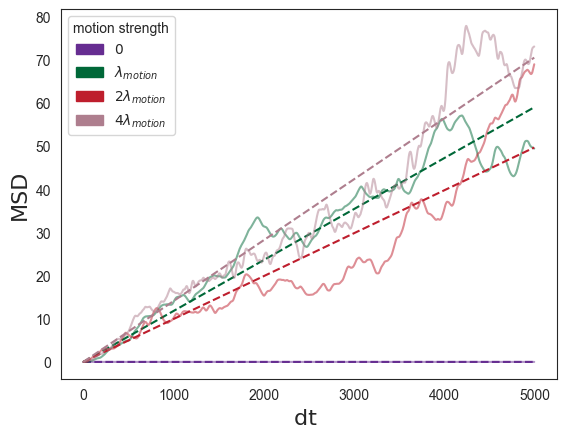

In [348]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch

import os
os.chdir("C:\\tmp\\differential_motion\\")

with open(f"data_test_speed10_msd.json", 'r') as f6:
    msd1 = json.load(f6)
with open(f"data_test_speed20_msd.json", 'r') as f6:
    msd2 = json.load(f6)
with open(f"data_test_speed30_msd.json", 'r') as f6:
    msd3 = json.load(f6)
with open(f"data_test_speed40_msd.json", 'r') as f6:
    msd4 = json.load(f6)
with open(f"data_test_speed50_msd.json", 'r') as f6:
    msd5 = json.load(f6)

merged_dict = {}
for key in msd1:
    merged_dict[key] = [(msd1[key][i] + msd2[key][i] + msd3[key][i] + msd4[key][i] + msd5[key][i]) / 5 for i in range(len(msd1[key]))]

print(merged_dict)

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']

# Create a list to store legend handles
legend_handles = []

# Define the legend labels
legend_labels = [r'0', r'$\lambda_{motion}$', r'2$\lambda_{motion}$', r'4$\lambda_{motion}$']

# Create a list to store mean speeds
mean_speeds = []

# Plot each track
for idx, (key, values) in enumerate(merged_dict.items()):
    # Get the color based on the index in the color palette
    color = color_palette[idx % len(color_palette)]

    plt.plot(values, color=color, alpha=0.5)

    # Create a legend handle with the plot
    legend_handle = Patch(color=color, label=legend_labels[idx])
    legend_handles.append(legend_handle)

    # Convert the cumulative_list to numpy array and reshape it
    y = np.array(values)

    # Create a corresponding array of indices as the independent variable
    X = np.arange(len(values)).reshape(-1, 1)

    # Fit the linear regression model
    reg = LinearRegression(fit_intercept=False).fit(X, y)

    # Infer y
    y_pred = reg.predict(X)

    # Print the slope (coefficient) and intercept of the linear regression model
    print("Slope (Coefficient):", f"{reg.coef_[0]:.6f}")

    plt.plot(X,y_pred, '--', color=color)



# Set the font properties for the legend
legend_font_props = {'family': 'Myriad Pro', 'size': 10}
plt.legend(handles=legend_handles, title='motion strength', prop=legend_font_props)

# Set the font properties for the axis labels
axis_label_font_props = {'family': 'Myriad Pro', 'size': 16}
plt.xlabel(r'dt ', fontdict=axis_label_font_props)
plt.ylabel(r'MSD', fontdict=axis_label_font_props)

# Save the plot to the data folder
plt.savefig(f"msd.png", transparent=False, dpi=500)

# Display the plot
plt.show()


## for single cell

dict_values([[2.6402662819555655e-08, 1.7886551151778083e-08, 4.1877598969868584e-08, 5.0017986445701306e-08, 3.516555335571901e-08, 6.910426871413401e-08, 9.5707906631132e-08, 1.9569547219415504e-08, 3.05129033406839e-08, 2.462214705533446e-08, 2.5614397535131432e-08, 4.1448321647545447e-08, 3.5870216452297024e-08, 2.2719147794957663e-08, 1.7790667776850203e-08, 1.7885357422954165e-08, 1.3965316141257059e-08, 1.692281441016171e-08, 1.3485827130674632e-08, 1.574649879694943e-08, 3.0728880414043374e-08, 2.323441611360988e-08, 1.0508963339383736e-08, 9.51742430892385e-09, 2.8891497940171635e-08, 8.84991819254508e-09, 1.7273281239149805e-08, 2.1990945101711485e-08, 8.059776140105686e-08, 6.470764438498908e-08, 2.779998157542396e-08, 3.861472775347089e-08, 2.9108597182857592e-08, 2.6185182084448213e-08, 2.004461053845701e-08, 2.7760545613535835e-08, 2.5282472119795558e-08, 1.8258070701176097e-08, 8.630487638195419e-09, 2.566988494801959e-08, 3.693883869824532e-08, 2.565543298526455e-08, 1.

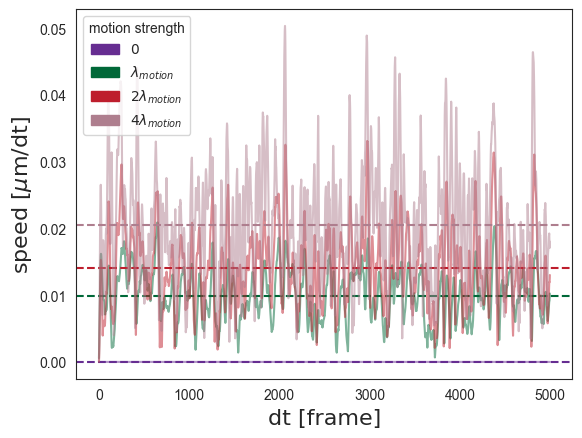

In [368]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch

import os
os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion0_uni1_speed.json", 'r') as f6:
    speed1 = json.load(f6)
with open(f"data_motion500_uni1_speed.json", 'r') as f6:
    speed2 = json.load(f6)
with open(f"data_motion1000_uni1_speed.json", 'r') as f6:
    speed3 = json.load(f6)
with open(f"data_motion2000_uni1_speed.json", 'r') as f6:
    speed4 = json.load(f6)

data_merged = [speed1, speed2, speed3, speed4]
print(speed1.values())

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']

# Create a list to store legend handles
legend_handles = []

# Define the legend labels
legend_labels = [r'0', r'$\lambda_{motion}$', r'2$\lambda_{motion}$', r'4$\lambda_{motion}$']

# Create a list to store mean speeds
mean_speeds = []

# Plot each track
for idx, dict in enumerate(data_merged):
    # Get the color based on the index in the color palette

    keys = list(dict.keys())
    values = list(dict.values())[0]
    x_values = range(len(values))

    color = color_palette[idx % len(color_palette)]

    plt.plot(values, color=color, alpha=0.5)
    # Calculate the mean of the track
    track_mean = np.mean(values)
    # Plot the mean as a horizontal line
    plt.axhline(track_mean, color=color, linestyle='--')

    # Create a legend handle with the plot
    legend_handle = Patch(color=color, label=legend_labels[idx])
    legend_handles.append(legend_handle)


# Set the font properties for the legend
legend_font_props = {'family': 'Myriad Pro', 'size': 10}
plt.legend(handles=legend_handles, title='motion strength', prop=legend_font_props)

# Set the font properties for the axis labels
axis_label_font_props = {'family': 'Myriad Pro', 'size': 16}
plt.xlabel(r'dt [frame]', fontdict=axis_label_font_props)
plt.ylabel(r'speed [$\mu$m/dt]', fontdict=axis_label_font_props)

# Save the plot to the data folder
plt.savefig(f"speed_single_cell_seed100.png", transparent=False, dpi=500)


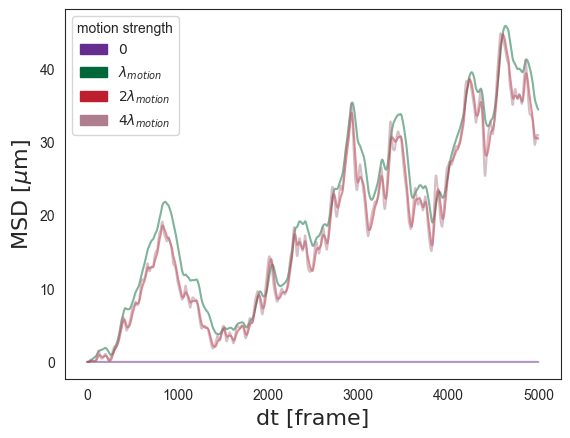

In [369]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch

import os
os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion0_uni1_msd.json", 'r') as f6:
    msd1 = json.load(f6)
with open(f"data_motion500_uni1_msd.json", 'r') as f6:
    msd2 = json.load(f6)
with open(f"data_motion1000_uni1_msd.json", 'r') as f6:
    msd3 = json.load(f6)
with open(f"data_motion2000_uni1_msd.json", 'r') as f6:
    msd4 = json.load(f6)

data_merged = [msd1, msd2, msd3, msd4]

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']

# Create a list to store legend handles
legend_handles = []

# Define the legend labels
legend_labels = [r'0', r'$\lambda_{motion}$', r'2$\lambda_{motion}$', r'4$\lambda_{motion}$']

# Create a list to store mean speeds
mean_speeds = []

# Plot each track
for idx, dict in enumerate(data_merged):
    # Get the color based on the index in the color palette

    keys = list(dict.keys())
    values = list(dict.values())[0]
    x_values = range(len(values))

    color = color_palette[idx % len(color_palette)]

    plt.plot(values, color=color, alpha=0.5)

    # Create a legend handle with the plot
    legend_handle = Patch(color=color, label=legend_labels[idx])
    legend_handles.append(legend_handle)

    '''# Convert the cumulative_list to numpy array and reshape it
    y = np.array(values)

    # Create a corresponding array of indices as the independent variable
    X = np.arange(len(values)).reshape(-1, 1)

    # Fit the linear regression model
    reg = LinearRegression(fit_intercept=False).fit(X, y)

    # Infer y
    y_pred = reg.predict(X)

    # Print the slope (coefficient) and intercept of the linear regression model
    print("Slope (Coefficient):", f"{reg.coef_[0]:.6f}")

    plt.plot(X,y_pred, '--', color=color)'''


# Set the font properties for the legend
legend_font_props = {'family': 'Myriad Pro', 'size': 10}
plt.legend(handles=legend_handles, title='motion strength', prop=legend_font_props)

# Set the font properties for the axis labels
axis_label_font_props = {'family': 'Myriad Pro', 'size': 16}
plt.xlabel(r'dt [frame]', fontdict=axis_label_font_props)
plt.ylabel(r'MSD [$\mu$m]', fontdict=axis_label_font_props)

# Save the plot to the data folder
plt.savefig(f"msd_single_cell_seed100_varyingstrength.png", transparent=False, dpi=500)


dict_values([[2.9233906875120175e-10, 2.6645091910637575e-08, 2.5856362029230695e-07, 1.18322364528467e-06, 3.7779088870593114e-06, 9.927726978276041e-06, 2.303347821452917e-05, 4.8614038178129704e-05, 9.461146623834793e-05, 0.00017169024636132235, 0.0002947598509308591, 0.00047645435779486434, 0.0007304497230506968, 0.0010675962016648555, 0.0015035917149361921, 0.002056392426311504, 0.0027324713264533784, 0.0035442294938548002, 0.004505712882746593, 0.005627226075375802, 0.00691327626191196, 0.008349851326784119, 0.009935227142705116, 0.011670187253912445, 0.013535675483581144, 0.015524969348916784, 0.01762204612896312, 0.01979285319976043, 0.021997504722094163, 0.02420693269232288, 0.026423550792969763, 0.02864177807350643, 0.030864685162669048, 0.033076867839554325, 0.035262100223917514, 0.03738962367060594, 0.039476035453844815, 0.04149975668406114, 0.04344045917969197, 0.045261781895533204, 0.04694432043470442, 0.04846992576494813, 0.04983355838339776, 0.051052628201432526, 0.0521

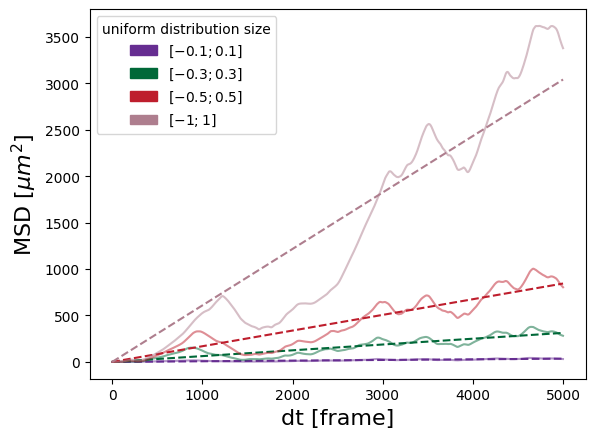

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch

import os
os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion500_uni1_msd.json", 'r') as f6:
    speed1 = json.load(f6)
with open(f"data_motion500_uni3_msd.json", 'r') as f6:
    speed2 = json.load(f6)
with open(f"data_motion500_uni5_msd.json", 'r') as f6:
    speed3 = json.load(f6)
with open(f"data_motion500_uni10_msd.json", 'r') as f6:
    speed4 = json.load(f6)

data_merged = [speed1, speed2, speed3, speed4]
print(speed1.values())

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']
marker_palette = ['o', '>', '+', '<']

# Create a list to store legend handles
legend_handles = []

# Define the legend labels
legend_labels = [r'$[-0.1; 0.1]$', r'$[-0.3; 0.3]$', r'$[-0.5; 0.5]$', r'$[-1; 1]$']

# Create a list to store mean speeds
mean_speeds = []

'''# Plot each track with log-log scale
for idx, data_dict in enumerate(data_merged):
    values = list(data_dict.values())[0]
    x_values = range(len(values))
    color = color_palette[idx % len(color_palette)]

    # Convert to log scale, ignoring the first data point (start at index 1)
    log_x_values = np.log(x_values[1:])
    log_values = np.log(values[1:])

    plt.plot(log_x_values, log_values, color=color, alpha=0.5)

    # Create a legend handle with the plot
    legend_handle = Patch(color=color, label=legend_labels[idx])
    legend_handles.append(legend_handle)

    # Fit the linear regression model
    #reg = LinearRegression(fit_intercept=False).fit(log_x_values, log_values)

    # Infer y (log scale)
    #y_pred = reg.predict(log_x_values)

    # Print the slope (coefficient) and intercept of the linear regression model
    #print("Slope (Coefficient):", f"{reg.coef_[0]:.6f}")

    #plt.plot(log_x_values, y_pred, '--', color=color)'''

# Plot each track
for idx, dict in enumerate(data_merged):
    # Get the color based on the index in the color palette

    keys = list(dict.keys())
    values = list(dict.values())[0]
    x_values = range(len(values))

    color = color_palette[idx % len(color_palette)]
    marker = marker_palette[idx % len(marker_palette)]

    plt.plot(values, color=color, alpha=0.5)

    # Create a legend handle with the plot
    legend_handle = Patch(color=color, label=legend_labels[idx])
    legend_handles.append(legend_handle)

    # Convert the cumulative_list to numpy array and reshape it
    y = np.array(values)

    # Create a corresponding array of indices as the independent variable
    X = np.arange(len(values)).reshape(-1, 1)

    # Fit the linear regression model
    reg = LinearRegression(fit_intercept=False).fit(X, y)

    # Infer y
    y_pred = reg.predict(X)

    # Print the slope (coefficient) and intercept of the linear regression model
    print("Slope (Coefficient):", f"{reg.coef_[0]:.6f}")

    plt.plot(X,y_pred, '--', color=color)

    # Calculate the mean of the track
    #track_mean = np.mean(values)
    # Plot the mean as a horizontal line
    #plt.axhline(track_mean, color=color, linestyle='--')



# Set the font properties for the legend
legend_font_props = {'family': 'Myriad Pro', 'size': 10}
plt.legend(handles=legend_handles, title='uniform distribution size', prop=legend_font_props)

# Set the font properties for the axis labels
axis_label_font_props = {'family': 'Myriad Pro', 'size': 16}
plt.xlabel(r'dt [frame]', fontdict=axis_label_font_props)
plt.ylabel(r'MSD [$\mu m^2$]', fontdict=axis_label_font_props)

'''plt.xlabel(r'log(dt)', fontdict=axis_label_font_props)
plt.ylabel(r'log(MSD)', fontdict=axis_label_font_props)
# Format the axis labels to show log scale
plt.xscale("log")
plt.yscale("log")


# Manually set the minor tick locations for both x and y axes
minor_locator = plt.MultipleLocator(base=0.5)
ax.yaxis.set_minor_locator(minor_locator)
ax.xaxis.set_minor_locator(minor_locator)

# Enable the minor ticks
plt.minorticks_on()'''

# Save the plot to the data folder
plt.savefig(f"msd_single_cell_seed100_varyingdistr.png", transparent=True, dpi=500)

In [246]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# Set the directory path
directory = "C:\\tmp\\differential_motion\\single_cell_motion_seed_1to100_uni1\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)
print(file_list)

# Initialize lists to store squared displacements for cell and force
squared_displacements_cell_list1 = []
squared_displacements_force_list1 = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_motion_path.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        track_cell = np.array(tracks["cell_A1_tracks"])
        track_force = np.array(tracks["motion_cell_A1_force_tracks"])

        # Get the initial 3D coordinates
        initial_coords_cell = np.array(track_cell[0])
        initial_coords_force = np.array(track_force[0])

        # Calculate the squared displacements for each time step
        squared_displacements_cell1 = [np.linalg.norm(np.array(coord) - initial_coords_cell)**2 for coord in track_cell]
        squared_displacements_force1 = [np.linalg.norm(np.array(coord) - initial_coords_force)**2 for coord in track_force]

        # Append the squared displacements to the lists
        squared_displacements_cell_list1.append(squared_displacements_cell1)
        squared_displacements_force_list1.append(squared_displacements_force1)

# Calculate the mean squared displacements
mean_squared_displacements_cell1 = np.mean(squared_displacements_cell_list1, axis=0)
mean_squared_displacements_force1 = np.mean(squared_displacements_force_list1, axis=0)



# Set the directory path
directory = "C:\\tmp\\differential_motion\\single_cell_motion_seed_1to100_uni3\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)
print(file_list)

# Initialize lists to store squared displacements for cell and force
squared_displacements_cell_list2 = []
squared_displacements_force_list2 = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_motion_path.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        track_cell = np.array(tracks["cell_A1_tracks"])
        track_force = np.array(tracks["motion_cell_A1_force_tracks"])

        # Get the initial 3D coordinates
        initial_coords_cell = np.array(track_cell[0])
        initial_coords_force = np.array(track_force[0])

        # Calculate the squared displacements for each time step
        squared_displacements_cell2 = [np.linalg.norm(np.array(coord) - initial_coords_cell)**2 for coord in track_cell]
        squared_displacements_force2 = [np.linalg.norm(np.array(coord) - initial_coords_force)**2 for coord in track_force]

        # Append the squared displacements to the lists
        squared_displacements_cell_list2.append(squared_displacements_cell2)
        squared_displacements_force_list2.append(squared_displacements_force2)

# Calculate the mean squared displacements
mean_squared_displacements_cell2 = np.mean(squared_displacements_cell_list2, axis=0)
mean_squared_displacements_force2 = np.mean(squared_displacements_force_list2, axis=0)



# Set the directory path
directory = "C:\\tmp\\differential_motion\\single_cell_motion_seed_1to100_uni5\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)
print(file_list)

# Initialize lists to store squared displacements for cell and force
squared_displacements_cell_list3 = []
squared_displacements_force_list3 = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_motion_path.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        track_cell = np.array(tracks["cell_A1_tracks"])
        track_force = np.array(tracks["motion_cell_A1_force_tracks"])

        # Get the initial 3D coordinates
        initial_coords_cell = np.array(track_cell[0])
        initial_coords_force = np.array(track_force[0])

        # Calculate the squared displacements for each time step
        squared_displacements_cell3 = [np.linalg.norm(np.array(coord) - initial_coords_cell)**2 for coord in track_cell]
        squared_displacements_force3 = [np.linalg.norm(np.array(coord) - initial_coords_force)**2 for coord in track_force]

        # Append the squared displacements to the lists
        squared_displacements_cell_list3.append(squared_displacements_cell3)
        squared_displacements_force_list3.append(squared_displacements_force3)

# Calculate the mean squared displacements
mean_squared_displacements_cell3 = np.mean(squared_displacements_cell_list3, axis=0)[:5000]
mean_squared_displacements_force3 = np.mean(squared_displacements_force_list3, axis=0)[:5000]



# Set the directory path
directory = "C:\\tmp\\differential_motion\\single_cell_motion_seed_1to100_uni10\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)
print(file_list)

# Initialize lists to store squared displacements for cell and force
squared_displacements_cell_list4 = []
squared_displacements_force_list4 = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_motion_path.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        track_cell = np.array(tracks["cell_A1_tracks"])
        track_force = np.array(tracks["motion_cell_A1_force_tracks"])

        # Get the initial 3D coordinates
        initial_coords_cell = np.array(track_cell[0])
        initial_coords_force = np.array(track_force[0])

        # Calculate the squared displacements for each time step
        squared_displacements_cell4 = [np.linalg.norm(np.array(coord) - initial_coords_cell)**2 for coord in track_cell]
        squared_displacements_force4 = [np.linalg.norm(np.array(coord) - initial_coords_force)**2 for coord in track_force]

        # Append the squared displacements to the lists
        squared_displacements_cell_list4.append(squared_displacements_cell4)
        squared_displacements_force_list4.append(squared_displacements_force4)

# Calculate the mean squared displacements
mean_squared_displacements_cell4 = np.mean(squared_displacements_cell_list4, axis=0)
mean_squared_displacements_force4 = np.mean(squared_displacements_force_list4, axis=0)

['data_100_contact_ratios.json', 'data_100_motion_path.json', 'data_100_msd.json', 'data_100_sorting_scores.json', 'data_100_speed.json', 'data_100_times.json', 'data_10_contact_ratios.json', 'data_10_motion_path.json', 'data_10_msd.json', 'data_10_sorting_scores.json', 'data_10_speed.json', 'data_10_times.json', 'data_11_contact_ratios.json', 'data_11_motion_path.json', 'data_11_msd.json', 'data_11_sorting_scores.json', 'data_11_speed.json', 'data_11_times.json', 'data_12_contact_ratios.json', 'data_12_motion_path.json', 'data_12_msd.json', 'data_12_sorting_scores.json', 'data_12_speed.json', 'data_12_times.json', 'data_13_contact_ratios.json', 'data_13_motion_path.json', 'data_13_msd.json', 'data_13_sorting_scores.json', 'data_13_speed.json', 'data_13_times.json', 'data_14_contact_ratios.json', 'data_14_motion_path.json', 'data_14_msd.json', 'data_14_sorting_scores.json', 'data_14_speed.json', 'data_14_times.json', 'data_15_contact_ratios.json', 'data_15_motion_path.json', 'data_15_m

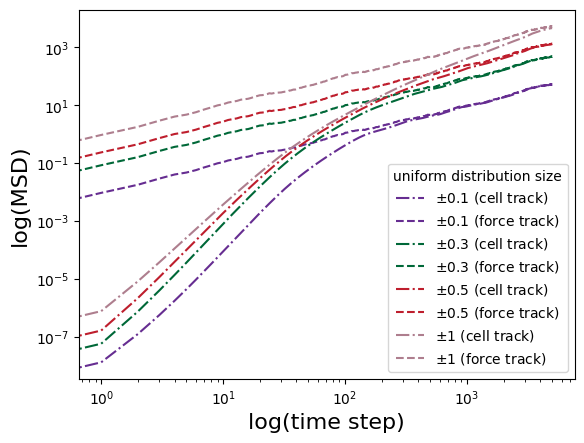

In [247]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import os

# Color and line style palettes
color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']
line_style_palette = ['-.', '--']

# Define the distribution sizes
distribution_sizes = [r'$\pm$0.1', r'$\pm$0.3', r'$\pm$0.5', r'$\pm$1']

# Create a list to store custom legend entries
legend_entries = []

for idx, msds in enumerate([(mean_squared_displacements_cell1, mean_squared_displacements_force1), 
                            (mean_squared_displacements_cell2, mean_squared_displacements_force2), 
                            (mean_squared_displacements_cell3, mean_squared_displacements_force3), 
                            (mean_squared_displacements_cell4, mean_squared_displacements_force4)]): 
    
    # Get the color for the legend entry
    color = color_palette[idx % len(color_palette)]

    # Create the custom legend entries for cell and force tracks
    legend_entry_cell = Line2D([], [], color=color, linestyle=line_style_palette[0], label=distribution_sizes[idx] + ' (cell track)')
    legend_entry_force = Line2D([], [], color=color, linestyle=line_style_palette[1], label=distribution_sizes[idx] + ' (force track)')

    # Append the legend entries to the list
    legend_entries.append(legend_entry_cell)
    legend_entries.append(legend_entry_force)

    # Plot the mean squared displacements for cell and force with log-log scale
    plt.loglog(msds[0], linestyle=line_style_palette[0], color=color)
    plt.loglog(msds[1], linestyle=line_style_palette[1], color=color)

# Set the font properties for the legend
legend_font_props = {'family': 'Myriad Pro', 'size': 10}
plt.legend(handles=legend_entries, title=r'uniform distribution size', prop=legend_font_props)

# Set the font properties for the axis labels
axis_label_font_props = {'family': 'Myriad Pro', 'size': 16}
plt.xlabel(r'log(time step)', fontdict=axis_label_font_props)
plt.ylabel(r'log(MSD)', fontdict=axis_label_font_props)

# Save the plot to the data folder
plt.savefig(f"_msd_single_cell_seed1to100.png", transparent=False, dpi=500)


data_100_speed.json
data_10_speed.json
data_11_speed.json
data_12_speed.json
data_13_speed.json
data_14_speed.json
data_15_speed.json
data_16_speed.json
data_17_speed.json
data_18_speed.json
data_19_speed.json
data_1_speed.json
data_20_speed.json
data_21_speed.json
data_22_speed.json
data_23_speed.json
data_24_speed.json
data_25_speed.json
data_26_speed.json
data_27_speed.json
data_28_speed.json
data_29_speed.json
data_2_speed.json
data_30_speed.json
data_31_speed.json
data_32_speed.json
data_33_speed.json
data_34_speed.json
data_35_speed.json
data_36_speed.json
data_37_speed.json
data_38_speed.json
data_39_speed.json
data_3_speed.json
data_40_speed.json
data_41_speed.json
data_42_speed.json
data_43_speed.json
data_44_speed.json
data_45_speed.json
data_46_speed.json
data_47_speed.json
data_48_speed.json
data_49_speed.json
data_4_speed.json
data_50_speed.json
data_51_speed.json
data_52_speed.json
data_53_speed.json
data_54_speed.json
data_55_speed.json
data_56_speed.json
data_57_speed.j

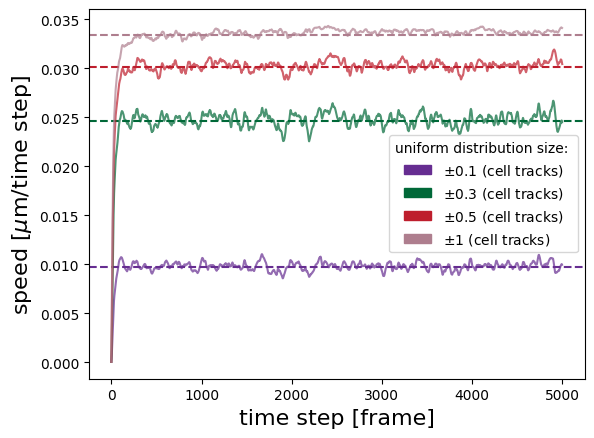

In [248]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# Set the directory path
directory = "C:\\tmp\\differential_motion\\single_cell_motion_seed_1to100_uni1\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)

speeds_cell_list = []
speeds_force_list = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_speed.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        speeds_cell = np.array(tracks["cell_A1_tracks"])
        speeds_force = np.array(tracks["motion_cell_A1_force_tracks"])
        
        # Append the squared displacements to the lists
        speeds_cell_list.append(speeds_cell)
        speeds_force_list.append(speeds_force)

# Calculate the mean squared displacements
mean_speeds_cell = np.mean(speeds_cell_list, axis=0)
mean_speeds_force = np.mean(speeds_force_list, axis=0)

#--

# Set the directory path
directory = "C:\\tmp\\differential_motion\\single_cell_motion_seed_1to100_uni3\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)

speeds_cell_list1 = []
speeds_force_list1 = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_speed.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        speeds_cell = np.array(tracks["cell_A1_tracks"])
        speeds_force = np.array(tracks["motion_cell_A1_force_tracks"])
        
        # Append the squared displacements to the lists
        speeds_cell_list1.append(speeds_cell)
        speeds_force_list1.append(speeds_force)

# Calculate the mean squared displacements
mean_speeds_cell1 = np.mean(speeds_cell_list1, axis=0)
mean_speeds_force1 = np.mean(speeds_force_list1, axis=0)


# Set the directory path
directory = "C:\\tmp\\differential_motion\\single_cell_motion_seed_1to100_uni5\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)

speeds_cell_list2 = []
speeds_force_list2 = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_speed.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        speeds_cell = np.array(tracks["cell_A1_tracks"])
        speeds_force = np.array(tracks["motion_cell_A1_force_tracks"])
        
        # Append the squared displacements to the lists
        speeds_cell_list2.append(speeds_cell)
        speeds_force_list2.append(speeds_force)

# Calculate the mean squared displacements
mean_speeds_cell2 = np.mean(speeds_cell_list2, axis=0)[:5000]
mean_speeds_force2 = np.mean(speeds_force_list2, axis=0)[:5000]


# Set the directory path
directory = "C:\\tmp\\differential_motion\\single_cell_motion_seed_1to100_uni10\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)

speeds_cell_list3 = []
speeds_force_list3 = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_speed.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        speeds_cell = np.array(tracks["cell_A1_tracks"])
        speeds_force = np.array(tracks["motion_cell_A1_force_tracks"])
        
        # Append the squared displacements to the lists
        speeds_cell_list3.append(speeds_cell)
        speeds_force_list3.append(speeds_force)

# Calculate the mean squared displacements
mean_speeds_cell3 = np.mean(speeds_cell_list3, axis=0)
mean_speeds_force3 = np.mean(speeds_force_list3, axis=0)

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']
# Create a list to store legend handles
legend_handles = []

# Define the legend labels
legend_labels = [r'$\pm$0.1 (cell tracks)', r'$\pm$0.3 (cell tracks)', r'$\pm$0.5 (cell tracks)', r'$\pm$1 (cell tracks)']


for idx, msd in enumerate([mean_speeds_cell, mean_speeds_cell1, mean_speeds_cell2, mean_speeds_cell3]): 

    color = color_palette[idx % len(color_palette)]
    # Create a legend handle with the plot
    legend_handle = Patch(color=color, label=legend_labels[idx])
    legend_handles.append(legend_handle)
    # Set the font properties for the legend
    legend_font_props = {'family': 'Myriad Pro', 'size': 10}
    plt.legend(handles=legend_handles, title=r'uniform distribution size: ', prop=legend_font_props)
    # Set the font properties for the axis labels
    axis_label_font_props = {'family': 'Myriad Pro', 'size': 16}
    plt.xlabel(r'time step [frame]', fontdict=axis_label_font_props)
    plt.ylabel(r'speed [$\mu$m/time step]', fontdict=axis_label_font_props)
    plt.plot(msd, color=color, alpha = 0.7)
    # Calculate the mean of the track
    track_mean = np.mean(msd)
    # Plot the mean as a horizontal line
    plt.axhline(track_mean, color=color, linestyle='--')



# Save the plot to the data folder
plt.savefig(f"_speed_single_cell_seed1to100.png", transparent=False, dpi=500)

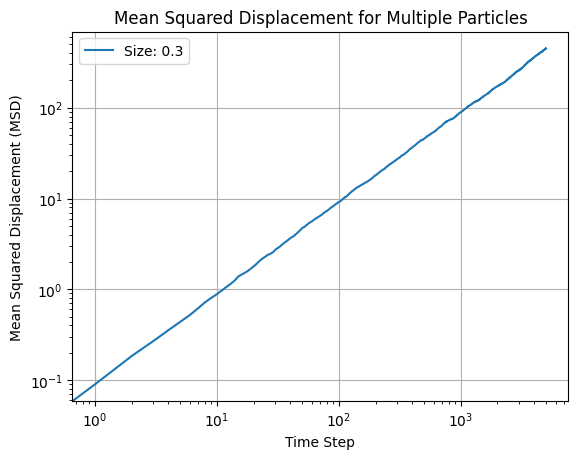

In [91]:
amplitudes = [0.3]
np.random.seed(100)

def generate_random_walks(num_particles, num_steps, amplitude):
    """
    Generate random walks for multiple particles using a uniform distribution.

    Parameters:
        num_particles (int): Number of particles.
        num_steps (int): Number of steps in each random walk.

    Returns:
        list: A list containing random walks for each particle.
    """
    random_walks = []

    for _ in range(num_particles):
        # Initial position of the particle
        initial_position = np.array([0, 0, 0])

        # Generate random steps using a uniform distribution
        random_steps = np.random.uniform(-amplitude, amplitude, size=(num_steps, 3))

        # Calculate the cumulative sum to get the random walk
        random_walk = np.cumsum(random_steps, axis=0) + initial_position

        random_walks.append(random_walk.tolist())

    return random_walks

# Number of particles
num_particles = 100

# Number of steps in each random walk
num_steps = 5000

# List to store MSD values for each amplitude
msd_values = []

for amplitude in amplitudes:
    # Generate the random walks for multiple particles with the given amplitude
    random_walks = generate_random_walks(num_particles, num_steps, amplitude)

    # Calculate the squared displacement for each particle at each time step
    squared_displacements = []
    for particle_walk in random_walks:
        squared_displacements_particle = [np.linalg.norm(np.array(coord) - np.array(particle_walk[0]))**2 for coord in particle_walk]
        squared_displacements.append(squared_displacements_particle)

    # Calculate the Mean Squared Displacement (MSD) over all particles for each time step
    msd = np.mean(squared_displacements, axis=0)
    msd_values.append(msd)


# Plot the MSD for each amplitude
for i, amplitude in enumerate(amplitudes):
    plt.loglog(range(num_steps), msd_values[i], label=f'Size: {amplitude}')

plt.xlabel('Time Step')
plt.ylabel('Mean Squared Displacement (MSD)')
plt.title('Mean Squared Displacement for Multiple Particles')
plt.legend()
plt.grid(True)
plt.show()

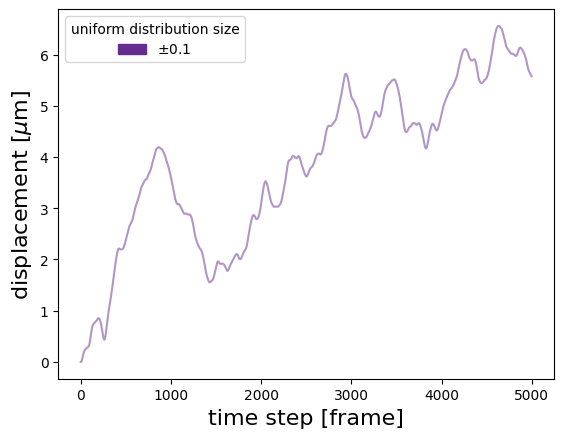

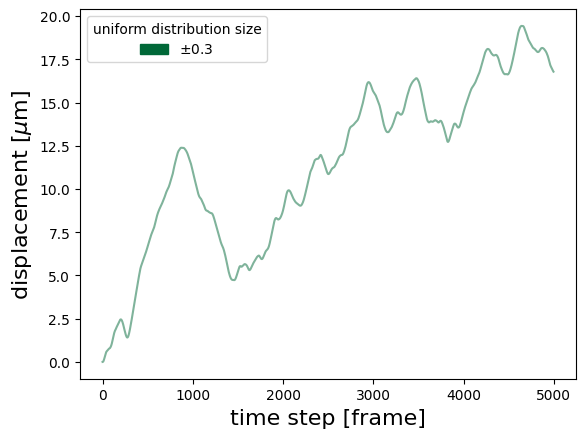

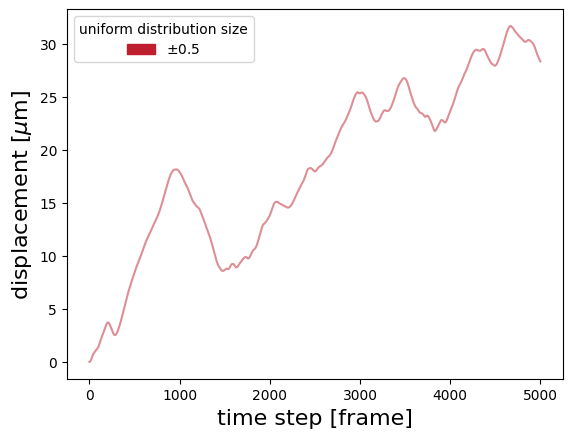

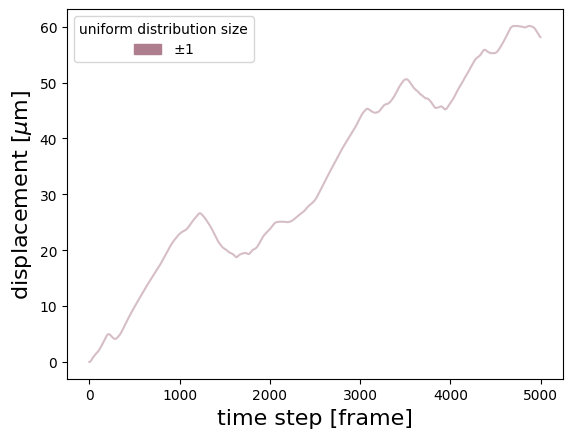

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression
import os

directory = "C:\\tmp\\differential_motion\\"
os.chdir(directory)


with open(f"single_cell_motion_seed_1to100_uni1\\data_100_msd.json", 'r') as f6:
    speed1 = json.load(f6)
with open(f"single_cell_motion_seed_1to100_uni3\\data_100_msd.json", 'r') as f6:
    speed2 = json.load(f6)
with open(f"single_cell_motion_seed_1to100_uni5\\data_100_msd.json", 'r') as f6:
    speed3 = json.load(f6)
with open(f"single_cell_motion_seed_1to100_uni10\\data_100_msd.json", 'r') as f6:
    speed4 = json.load(f6)
#with open(f"data_motion500_uni10_msd.json", 'r') as f6:
#    speed4 = json.load(f6)

data_merged = [speed1, speed2, speed3, speed4] #, speed4

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']
marker_palette = ['o', '>', '+', '<']

# Define the legend labels
legend_labels = [r'$\pm$0.1', r'$\pm$0.3', r'$\pm$0.5', r'$\pm$1']

# Plot each track on a new figure
for idx, data_dict in enumerate(data_merged):
    plt.figure()  # Create a new figure for each iteration
    ax = plt.gca()

    values = list(data_dict.values())[0][:5000]
    x_values = range(len(values))
    color = color_palette[idx % len(color_palette)]
    marker = marker_palette[idx % len(marker_palette)]

    plt.plot([math.sqrt(value) for value in values], color=color, alpha=0.5)

    # Create a legend handle with the plot
    legend_handle = Patch(color=color, label=legend_labels[idx])
    plt.legend(handles=[legend_handle], title='uniform distribution size', prop={'family': 'Myriad Pro', 'size': 10})

    # Convert the cumulative_list to numpy array and reshape it
    y = np.array(values)
    X = np.arange(len(values)).reshape(-1, 1)

    # Fit the linear regression model
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    y_pred = reg.predict(X)

    #plt.plot(X, y_pred, '--', color=color)

    plt.xlabel(r'time step [frame]', fontdict={'family': 'Myriad Pro', 'size': 16})
    plt.ylabel(r'displacement [$\mu$m]', fontdict={'family': 'Myriad Pro', 'size': 16})

    # Save the plot to the data folder
    plt.savefig(f"_msd_single_cell_seed100_{idx}.png", transparent=True, dpi=500)


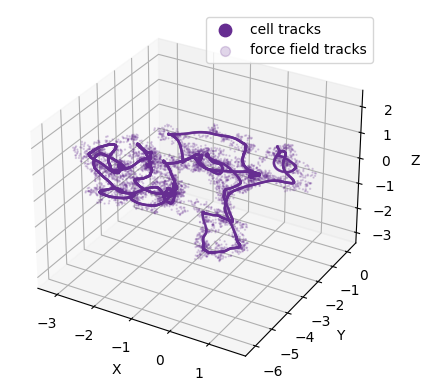

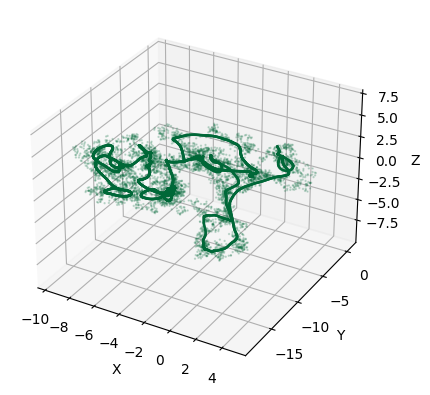

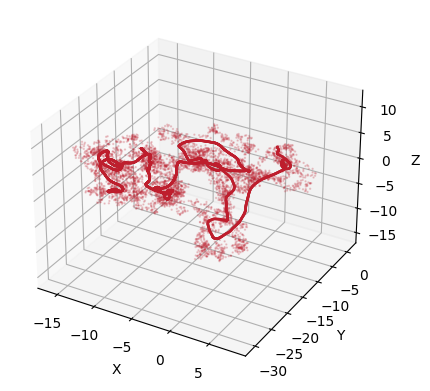

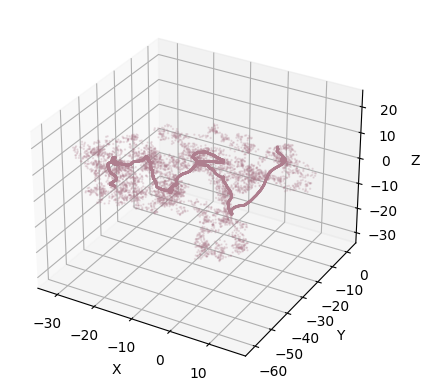

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression
import os

directory = "C:\\tmp\\differential_motion\\"
os.chdir(directory)


with open(f"single_cell_motion_seed_1to100_uni1\\data_100_motion_path.json", 'r') as f6:
    tracks1 = json.load(f6)
with open(f"single_cell_motion_seed_1to100_uni3\\data_100_motion_path.json", 'r') as f6:
    tracks2 = json.load(f6)
with open(f"single_cell_motion_seed_1to100_uni5\\data_100_motion_path.json", 'r') as f6:
    tracks3 = json.load(f6)
with open(f"single_cell_motion_seed_1to100_uni10\\data_100_motion_path.json", 'r') as f6:
    tracks4 = json.load(f6)

data_merged = [tracks1, tracks2, tracks3, tracks4]

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']

# Define the legend labels
legend_labels = [r'$[-0.1; 0.1]$', r'$[-0.3; 0.3]$', r'$[-0.5; 0.5]$', r'$[-1; 1]$']

# Plot each track on a new figure
for idx, tracks in enumerate(data_merged):

    # Extract the tracks from the dictionary
    track1_cell = np.array(tracks["cell_A1_tracks"])[:5000]
    track1_force = np.array(tracks["motion_cell_A1_force_tracks"])[:5000]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color = color_palette[idx % len(color_palette)]

    # Plot track1 in blue
    p1 = ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], marker = 'o', c=color, s=0.8, label='cell tracks')
    # Plot track2 in red
    p2 = ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], marker = 'o', c=color, alpha = 0.2, s=0.5, label='force field tracks')

    # Set labels and title
    ax.set_xlabel('X')
    #ax.set_xlim(-20,-2)
    ax.set_ylabel('Y')
    #ax.set_ylim(-1,20)
    ax.set_zlabel('Z')
    #ax.set_zlim(-20,-5)

    if idx == 0: 
        # Add a legend
        ax.legend(handles=[p1, p2], labels=['cell tracks', 'force field tracks'], markerscale=10)

    # Save the plot to the data folder
    plt.savefig(f"_tracks_seed100_uni_{idx}.png", transparent=True, dpi=500)


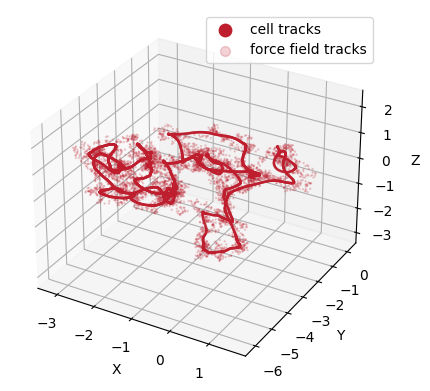

In [202]:
# seed = 100
directory = "C:\\tmp\\differential_motion\\"
os.chdir(directory)

with open(f"single_cell_motion_seed_1to100_uni1\\data_100_motion_path.json", 'r') as f6:
    tracks = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A1_tracks"])
track1_force = np.array(tracks["motion_cell_A1_force_tracks"])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot track1 in blue
p1 = ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], marker = 'o', c='#BE1E2D', s=0.8, label='cell tracks')

# Plot track2 in red
p2 = ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], marker = 'o', c='#BE1E2D', alpha = 0.2, s=0.5, label='force field tracks')

# Set labels and title
ax.set_xlabel('X')
#ax.set_xlim(-20,-2)
ax.set_ylabel('Y')
#ax.set_ylim(-1,20)
ax.set_zlabel('Z')
#ax.set_zlim(-20,-5)

# Add a legend
ax.legend(handles=[p1, p2], labels=['cell tracks', 'force field tracks'], markerscale=10)

# Save the plot to the data folder
plt.savefig(f"_tracks_seed100_uni1.png", transparent=False, dpi=500)

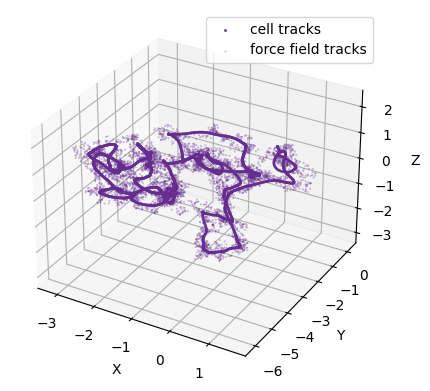

In [119]:
# seed = 100
os.chdir("C:\\tmp\\differential_motion\\seed100")
color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']

with open(f"data_motion500_uni1_motion_path.json", 'r') as f6:
    tracks = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A1_tracks"])
track1_force = np.array(tracks["motion_cell_A1_force_tracks"])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot track1 in blue
ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], c='#662D91', s=1, label='cell tracks')

# Plot track2 in red
ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], c='#662D91', alpha = 0.5, s=0.1, label='force field tracks')

# Set labels and title
ax.set_xlabel('X')
#ax.set_xlim(-20,20)
ax.set_ylabel('Y')
#ax.set_ylim(-20,20)
ax.set_zlabel('Z')
#ax.set_zlim(-20,20)

# Add a legend
ax.legend()

# Save the plot to the data folder
plt.savefig(f"tracks_seed100_uni1.png", transparent=False, dpi=500)

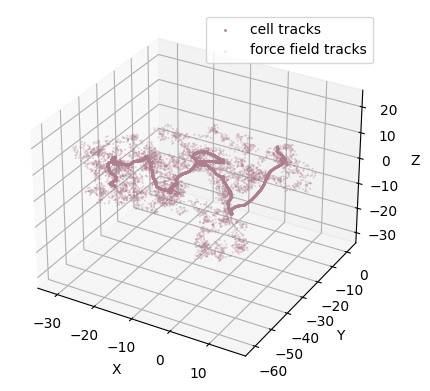

In [123]:
# seed = 100
os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion500_uni10_motion_path.json", 'r') as f6:
    tracks = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A1_tracks"])
track1_force = np.array(tracks["motion_cell_A1_force_tracks"])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot track1 in blue
ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], c='#AE7E8E', s=1, label='cell tracks')

# Plot track2 in red
ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], c='#AE7E8E', alpha = 0.5, s=0.1, label='force field tracks')

# Set labels and title
ax.set_xlabel('X')
#ax.set_xlim(-20,20)
ax.set_ylabel('Y')
#ax.set_ylim(-20,20)
ax.set_zlabel('Z')
#ax.set_zlim(-20,20)

# Add a legend
ax.legend()

# Save the plot to the data folder
plt.savefig(f"tracks_seed100_uni10.png", transparent=False, dpi=500)

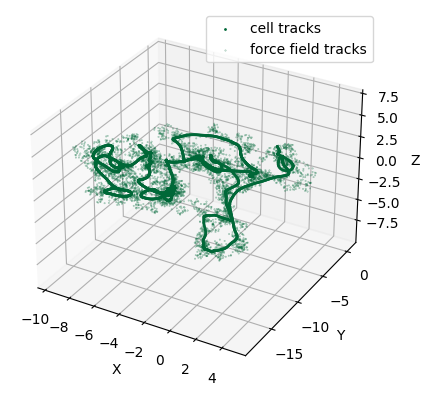

In [131]:
# seed = 100
os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion500_uni3_motion_path.json", 'r') as f6:
    tracks = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A1_tracks"])
track1_force = np.array(tracks["motion_cell_A1_force_tracks"])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot track1 in blue
ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], c='#006838', s=1, label='cell tracks')

# Plot track2 in red
ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], c='#006838', alpha = 0.5, s=0.1, label='force field tracks')

# Set labels and title
ax.set_xlabel('X')
#ax.set_xlim(-20,-2)
ax.set_ylabel('Y')
#ax.set_ylim(-1,20)
ax.set_zlabel('Z')
#ax.set_zlim(-20,-5)

# Add a legend
ax.legend()

# Save the plot to the data folder
plt.savefig(f"tracks_seed100_uni3.png", transparent=False, dpi=500)

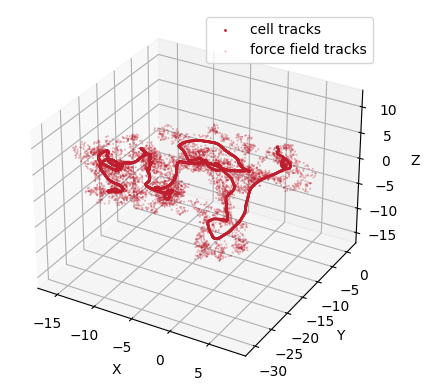

In [135]:
# seed = 100
os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion500_uni5_motion_path.json", 'r') as f6:
    tracks = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A1_tracks"])
track1_force = np.array(tracks["motion_cell_A1_force_tracks"])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot track1 in blue
ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], c='#BE1E2D', s=1, label='cell tracks')

# Plot track2 in red
ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], c='#BE1E2D', alpha = 0.5, s=0.1, label='force field tracks')

# Set labels and title
ax.set_xlabel('X')
#ax.set_xlim(-20,-2)
ax.set_ylabel('Y')
#ax.set_ylim(-1,20)
ax.set_zlabel('Z')
#ax.set_zlim(-20,-5)

# Add a legend
ax.legend()

# Save the plot to the data folder
plt.savefig(f"tracks_seed100_uni5.png", transparent=False, dpi=500)

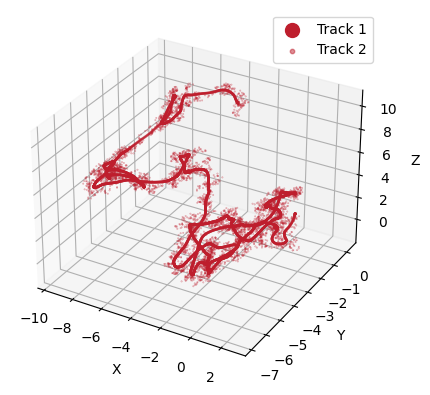

In [144]:
# seed = 100
os.chdir("C:\\tmp\\differential_motion\\")

with open(f"data2_motion_path.json", 'r') as f6:
    tracks = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A1_tracks"])
track1_force = np.array(tracks["motion_cell_A1_force_tracks"])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot track1 in blue
p1 = ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], c='#BE1E2D', s=1, label='cell tracks')

# Plot track2 in red
p2 = ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], c='#BE1E2D', alpha = 0.5, s=0.1, label='force field tracks')

# Set labels and title
ax.set_xlabel('X')
#ax.set_xlim(-20,-2)
ax.set_ylabel('Y')
#ax.set_ylim(-1,20)
ax.set_zlabel('Z')
#ax.set_zlim(-20,-5)

# Add a legend
ax.legend(handles=[p1, p2], labels=['Track 1', 'Track 2'], markerscale=10)

# Save the plot to the data folder
plt.savefig(f"tracks_seed100_uni5.png", transparent=False, dpi=500)

In [153]:
# seed = 100

os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion500_uni1_motion_path.json", 'r') as f6:
    tracks1 = json.load(f6)
with open(f"data_motion500_uni3_motion_path.json", 'r') as f6:
    tracks2 = json.load(f6)
with open(f"data_motion500_uni5_motion_path.json", 'r') as f6:
    tracks3 = json.load(f6)
with open(f"data_motion500_uni10_motion_path.json", 'r') as f6:
    tracks4 = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks1["cell_A1_tracks"])
track1_force = np.array(tracks1["motion_cell_A1_force_tracks"])
# Extract the tracks from the dictionary
track2_cell = np.array(tracks2["cell_A1_tracks"])
track2_force = np.array(tracks2["motion_cell_A1_force_tracks"])
# Extract the tracks from the dictionary
track3_cell = np.array(tracks3["cell_A1_tracks"])
track3_force = np.array(tracks3["motion_cell_A1_force_tracks"])
# Extract the tracks from the dictionary
track4_cell = np.array(tracks4["cell_A1_tracks"])
track4_force = np.array(tracks4["motion_cell_A1_force_tracks"])

# Calculate the mean squared residual (MSR)
squared_diff = (track4_cell - track4_force) ** 2
msr = np.mean(np.sum(squared_diff, axis=1))
print("Mean Squared Residual:", msr)

Mean Squared Residual: 152.26854292583306


## dynamic time wrapping

999
DTW Distance: 240.20517457198386
Euclidean Distance: [0.16429957 0.1970996  0.24634775 0.27864558 0.36306094 0.40172765
 0.47260022 0.51136158 0.57582699 0.64654873 0.54407171 0.50161797
 0.46145916 0.5159439  0.52844809 0.39441743 0.40306779 0.41444822
 0.38880138 0.32491249 0.16520395 0.17811502 0.21474165 0.11840742
 0.12360329 0.18864083 0.27570981 0.32423179 0.30689778 0.27526497
 0.33051747 0.34965787 0.34648216 0.35343588 0.38403567 0.26307035
 0.37081048 0.40282875 0.45590475 0.45689723 0.50374777 0.5046689
 0.47295828 0.36643922 0.43662946 0.27478736 0.18561265 0.25033252
 0.2510677  0.26511876 0.22734497 0.21270393 0.24393651 0.18873762
 0.20122822 0.17401765 0.15747991 0.19605435 0.15204025 0.16633194
 0.12568323 0.132608   0.15736582 0.18559882 0.2598344  0.19541513
 0.26560876 0.27640745 0.36959224 0.41261675 0.42898501 0.49211149
 0.45481842 0.37573414 0.43837091 0.41030034 0.40524524 0.40386112
 0.32771804 0.27219681 0.35302877 0.36813762 0.38287665 0.41599081
 0.406

'# Extract the tracks from the dictionary\ntrack1_cell = np.array(tracks["cell_A2_tracks"][:-1])\ntrack1_force = np.array(tracks["motion_cell_A2_force_tracks"])\n\n# Apply Dynamic Time Warping\ndistance, path = fastdtw(track1_cell, track1_force)\n\nprint("DTW Distance:", distance)\n\n# Extract the tracks from the dictionary\ntrack1_cell = np.array(tracks["cell_A3_tracks"][:-1])\ntrack1_force = np.array(tracks["motion_cell_A3_force_tracks"])\n\n# Apply Dynamic Time Warping\ndistance, path = fastdtw(track1_cell, track1_force)\n\nprint("DTW Distance:", distance)\n\n# Extract the tracks from the dictionary\ntrack1_cell = np.array(tracks["cell_A4_tracks"][:-1])\ntrack1_force = np.array(tracks["motion_cell_A4_force_tracks"])\n\n# Apply Dynamic Time Warping\ndistance, path = fastdtw(track1_cell, track1_force)\n\nprint("DTW Distance:", distance)'

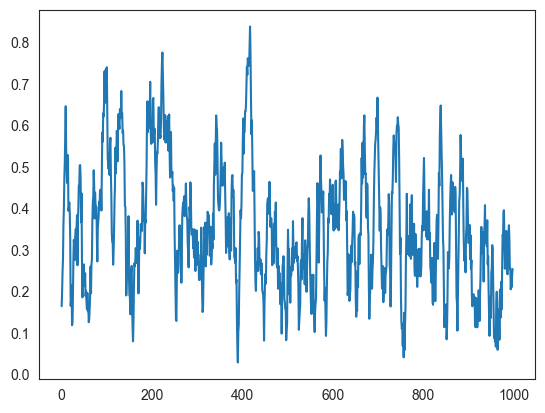

In [414]:
os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion2000_seed100_uni3_motion_path.json", 'r') as f6:
    tracks = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A1_tracks"])
track1_force = np.array(tracks["motion_cell_A1_force_tracks"])
print(len(track1_cell))

# Apply Dynamic Time Warping
distance, path = fastdtw(track1_cell, track1_force)
print("DTW Distance:", distance)

# Compute the Euclidean distance between the sequences of coordinates
distances = np.linalg.norm(track1_cell - track1_force, axis=1)
print("Euclidean Distance:", distances)
plt.plot(distances)

'''# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A2_tracks"][:-1])
track1_force = np.array(tracks["motion_cell_A2_force_tracks"])

# Apply Dynamic Time Warping
distance, path = fastdtw(track1_cell, track1_force)

print("DTW Distance:", distance)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A3_tracks"][:-1])
track1_force = np.array(tracks["motion_cell_A3_force_tracks"])

# Apply Dynamic Time Warping
distance, path = fastdtw(track1_cell, track1_force)

print("DTW Distance:", distance)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A4_tracks"][:-1])
track1_force = np.array(tracks["motion_cell_A4_force_tracks"])

# Apply Dynamic Time Warping
distance, path = fastdtw(track1_cell, track1_force)

print("DTW Distance:", distance)'''

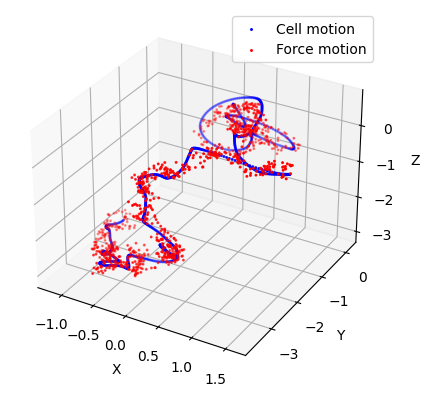

In [18]:
os.chdir("C:\\tmp\\differential_motion\\seed100")

with open(f"data_motion2000_seed100_uni3_motion_path.json", 'r') as f6:
    tracks = json.load(f6)

# Extract the tracks from the dictionary
track1_cell = np.array(tracks["cell_A1_tracks"])
track1_force = np.array(tracks["motion_cell_A1_force_tracks"])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot track1 in blue
ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], c='blue', s=1.2, label='Cell motion')

# Plot track2 in red
ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], c='red', s=1.2, label='Force motion')



'''# Project the coordinates on the XY, XZ, and YZ planes
xy_projection = track1_cell[:, :2]
xz_projection = np.hstack((track1_cell[:, [0, 2]], np.zeros((track1_cell.shape[0], 1))))
yz_projection = track1_cell[:, 1:]

# Plot projections on the XY plane in green
ax.scatter(xy_projection[:, 0], xy_projection[:, 1], np.zeros(xy_projection.shape[0]), c='green', label='XY Projection')

# Plot projections on the XZ plane in orange
ax.scatter(xz_projection[:, 0], np.zeros(xz_projection.shape[0]), xz_projection[:, 1], c='orange', label='XZ Projection')

# Plot projections on the YZ plane in purple
ax.scatter(np.zeros(yz_projection.shape[0]), yz_projection[:, 0], yz_projection[:, 1], c='purple', label='YZ Projection')'''

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [254]:
'''avg_msd = {}
std_dev_msd = {}

# Iterate over the keys in msd0 (assuming it has the same keys as the other msd variables)
for key in msd0.keys():
    msd_values = [list(itertools.accumulate(msd[key])) for msd in msd_vars]
    avg_msd[key] = np.mean(msd_values, axis=0)
    std_dev_msd[key] = np.std(msd_values, axis=0)'''

'avg_msd = {}\nstd_dev_msd = {}\n\n# Iterate over the keys in msd0 (assuming it has the same keys as the other msd variables)\nfor key in msd0.keys():\n    msd_values = [list(itertools.accumulate(msd[key])) for msd in msd_vars]\n    avg_msd[key] = np.mean(msd_values, axis=0)\n    std_dev_msd[key] = np.std(msd_values, axis=0)'

In [255]:
'''legend_str = list()
count = 0 
#colors = ['red', 'orangered', 'indianred', 'maroon']
colors = ['red', 'green', 'purple', 'orange']
strength = [0, 500, 1000, 2000]

for key, avg_val in avg_msd.items(): 
    #log_idx = [math.log(x) for x in idx]
    #cumulative_idx = list(itertools.accumulate(idx))
    #log_cumulative_idx = [math.log(x) for x in cumulative_idx]

    # Convert the cumulative_list to numpy array and reshape it
    y = np.array(avg_val)

    # Create a corresponding array of indices as the independent variable
    X = np.arange(len(times1)/2 -1 ).reshape(-1, 1)

    # Fit the linear regression model
    reg = LinearRegression().fit(X, y)

    # Infer y
    y_pred = reg.predict(X)

    # Print the slope (coefficient) and intercept of the linear regression model
    print("Slope (Coefficient):", f"strength = {strength[count]}; {reg.coef_[0]:.6f}")
    #print("Intercept:", reg.intercept_)
    #legend_str.append(f" {reg.coef_[0]:.9f}")

    # Plot
    #plt.plot(X,y_pred, '--')
    #plt.plot(X, idx, label = f"{reg.coef_[0]:.6f}")

    # Plot mean with standard deviation
    plt.errorbar(X, avg_val, yerr = std_dev_msd[key], fmt='-', 
                color = colors[count], ecolor = colors[count], 
                label = f"{reg.coef_[0]:.6f}", linewidth = 0.5, 
                alpha = 0.8, 
                capsize = 0, elinewidth = 0.01, capthick = 0.2)
    # yerr=std_dev_msd[key],
    count += 1

# Create two separate legends
legend1 = plt.legend(title = 'self-diffusivity (slope)\n', bbox_to_anchor=(0.55, 0.821), loc='center right')
legend2 = plt.legend(['0', '500', '1000', '2000'], title = 'motion strength \n', loc='upper left')

# Add the legends to the plot
#plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
# labels and legend
plt.ylabel(r'MSD [-]')
plt.xlabel(r'frame [-]')
#plt.legend(title = r'$falloff\_power = 0;   strength = -1000$')
#plt.legend([r'$motion = 750$', r'$motion = 250$', r'n=5'])
#plt.text(0.95, 0.05, r'n=5', ha='right', va='bottom', transform=plt.gca().transAxes)
locs, labels = xticks()

# plot save to data foler
plt.savefig(f"MSD.png", transparent = False, dpi=500)'''

'legend_str = list()\ncount = 0 \n#colors = [\'red\', \'orangered\', \'indianred\', \'maroon\']\ncolors = [\'red\', \'green\', \'purple\', \'orange\']\nstrength = [0, 500, 1000, 2000]\n\nfor key, avg_val in avg_msd.items(): \n    #log_idx = [math.log(x) for x in idx]\n    #cumulative_idx = list(itertools.accumulate(idx))\n    #log_cumulative_idx = [math.log(x) for x in cumulative_idx]\n\n    # Convert the cumulative_list to numpy array and reshape it\n    y = np.array(avg_val)\n\n    # Create a corresponding array of indices as the independent variable\n    X = np.arange(len(times1)/2 -1 ).reshape(-1, 1)\n\n    # Fit the linear regression model\n    reg = LinearRegression().fit(X, y)\n\n    # Infer y\n    y_pred = reg.predict(X)\n\n    # Print the slope (coefficient) and intercept of the linear regression model\n    print("Slope (Coefficient):", f"strength = {strength[count]}; {reg.coef_[0]:.6f}")\n    #print("Intercept:", reg.intercept_)\n    #legend_str.append(f" {reg.coef_[0]:.9f}")

# Contact area

In [5]:
os.chdir("C:\\tmp\\paper_data\\adhesion_paper\\")

with open(f"data1_contact_ratios.json", 'r') as f6:
    ratios1 = json.load(f6)
    # Extract the keys and values from the dictionary
    # Remove underscores from keys
    keys = [key.replace('_', '') for key in ratios1.keys()]
    values = [value[0] for value in ratios1.values()]

with open(f"data2_contact_ratios.json", 'r') as f6:
    ratios2 = json.load(f6)

with open(f"data3_contact_ratios.json", 'r') as f6:
    ratios3 = json.load(f6)

with open(f"data4_contact_ratios.json", 'r') as f6:
    ratios4 = json.load(f6)

with open(f"data5_contact_ratios.json", 'r') as f6:
    ratios5 = json.load(f6)

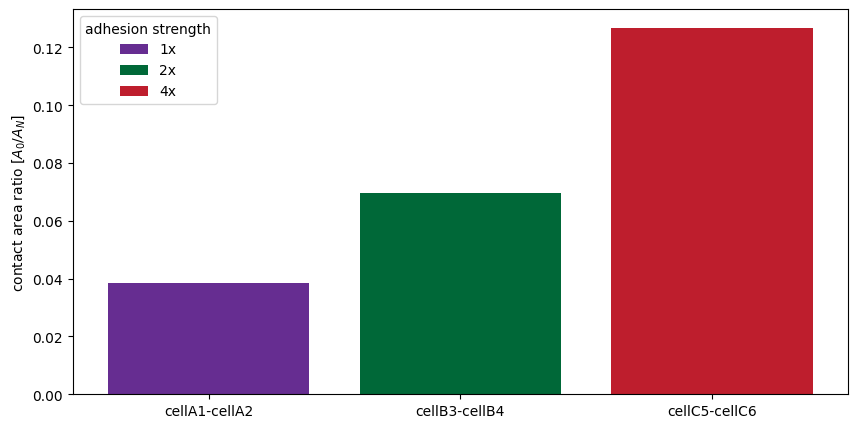

In [6]:

# Define the figure size
fig, ax = plt.subplots(figsize=(10, 5))

# Define a color palette
color_palette = ['#662D91', '#006838', '#BE1E2D']

# Assign colors to bars based on their order
bar_colors = [color_palette[i % len(color_palette)] for i in range(len(keys))]

# Plot the data with customized colors
plt.bar(keys, values, color=bar_colors)
#plt.xticks(rotation=45)

plt.ylabel(r'contact area ratio $[A_0/A_N]$')

# Create custom legend handles
legend_handles = [Patch(facecolor=color_palette[i % len(color_palette)], label=label)
                  for i, label in enumerate(['1x', '2x', '4x'])]

# Add legend with custom handles
plt.legend(handles=legend_handles, title='adhesion strength')
# Set the figure size
#fig.set_size_inches(5, 6)
#plt.tight_layout()


# Save the plot
plt.savefig("contact_ratios.png", transparent=False, dpi=500)

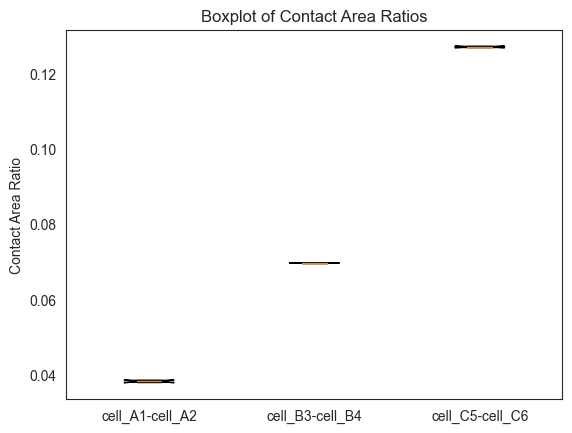

In [10]:

# Combine values from both dictionaries
values = [ratios1[key] + ratios2[key] + ratios3[key] + ratios4[key] for key in ratios1]

# Create labels from dictionary keys
labels = list(ratios1.keys())

# Plot the boxplot
plt.boxplot(values, patch_artist=True, notch=True, vert=True, labels=labels)

# Add labels and title
plt.ylabel('Contact Area Ratio')
plt.title('Boxplot of Contact Area Ratios')

# Save the plot
plt.savefig("contact_ratios_boxplot.png", transparent=False, dpi=500)

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


{'cell_A1-cell_A2': [0.03848682694240076, 0.03848682694240076, 0.03795171529164701, 0.03795171529164701, 0.03795171529164701], 'cell_B3-cell_B4': [0.06964820577411933, 0.06964820577411933, 0.06965595684481907, 0.06965595684481907, 0.06965595684481907], 'cell_C5-cell_C6': [0.12688215583533263, 0.12688215583533263, 0.1271906784178395, 0.1271906784178395, 0.1271906784178395]}
[0.00026215009995301906, 3.7972336349191e-06, 0.00015114458025350307]


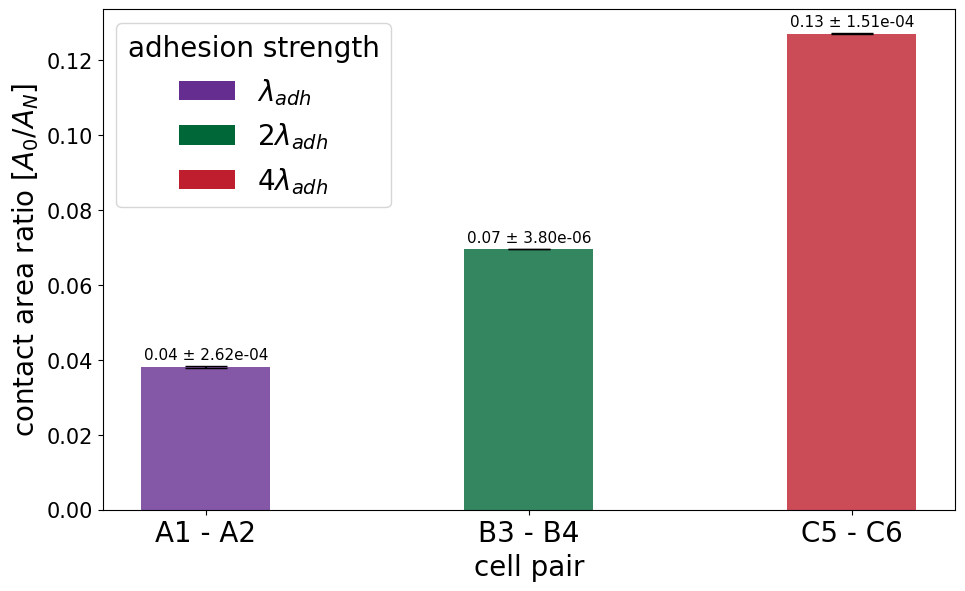

In [7]:
# Define the figure size
fig, ax = plt.subplots(figsize=(11, 6.5))

# Define a color palette
color_palette = ['#662D91', '#006838', '#BE1E2D']
font_props = {'family': 'Myriad Pro', 'size': 20}
font_props_text = {'family': 'Myriad Pro', 'size': 11}
title_font = FontProperties(family='Myriad Pro',  size=20)

# Assign colors to bars based on their order
bar_colors = [color_palette[i % len(color_palette)] for i in range(len(keys))]

# Combine dictionaries
combined_dict = {}
for key in ratios1:
    if key in ratios2:
        combined_dict[key] = ratios1[key] + ratios2[key] + ratios3[key] + ratios4[key] + ratios5[key]

print(combined_dict)

# Calculate the mean and standard deviation
values = [np.mean(combined_dict[key]) for key in combined_dict]
std = [np.std(combined_dict[key]) for key in combined_dict]
print(std)

# Create labels from dictionary keys
labels = [key.replace('_', '') for key in combined_dict.keys()]
labels = [key.replace('-', ' - ') for key in labels]
labels = [key.replace('cell', '') for key in labels]
# Convert labels to strings explicitly
labels = [str(label) for label in labels]

# Set the width of the bars
#bar_width = 0.35

# Set the positions of the x-axis ticks
x = np.arange(len(labels))

# Plot the bar plot with error bars
plt.bar(x, values, width = 0.4, yerr=std, capsize=15,color=bar_colors, alpha=.8)

# Add labels and title
plt.ylabel(r'contact area ratio $[A_0/A_N]$', fontproperties=font_props)
plt.xlabel(r'cell pair', fontproperties=font_props)
plt.yticks(fontsize=15)
plt.xticks(fontsize=18)

# Set the x-axis tick labels
plt.xticks(x, labels, fontproperties=font_props)

# Create custom legend handles
legend_handles = [Patch(facecolor=color_palette[i % len(color_palette)], label=label)
                  for i, label in enumerate([r'$\lambda_{adh}$', r'2$\lambda_{adh}$', r'4$\lambda_{adh}$'])]

# Add legend with custom handles
plt.legend(handles=legend_handles, title='adhesion strength', title_fontproperties= font_props, prop = font_props)
# Set the figure size

# Add text box with std dev values
offset = 0.001  # Adjust the offset value as needed
for x, value, std_dev in zip(x, values, std):
    std_dev_str = "{:.2e}".format(std_dev)
    text = f"{value:.2f} \u00B1 {std_dev_str}"
    plt.text(x, value + std_dev + offset, text, ha='center', va='bottom', fontdict=font_props_text)

#plt.subplots_adjust(bottom=0.2)
# Save the plot
plt.savefig("contact_ratios.png", transparent=False, dpi=500)

In [9]:
from scipy.stats import ttest_ind

# Combine the data into a list for each group (A, B, and C)
group_A = ratios1["cell_A1-cell_A2"] + ratios2["cell_A1-cell_A2"] + ratios3["cell_A1-cell_A2"] + ratios4["cell_A1-cell_A2"] + ratios5["cell_A1-cell_A2"]
group_B = ratios1["cell_B3-cell_B4"] + ratios2["cell_B3-cell_B4"] + ratios3["cell_B3-cell_B4"] + ratios4["cell_B3-cell_B4"] + ratios5["cell_B3-cell_B4"]
group_C = ratios1["cell_C5-cell_C6"] + ratios2["cell_C5-cell_C6"] + ratios3["cell_C5-cell_C6"] + ratios4["cell_C5-cell_C6"] + ratios5["cell_C5-cell_C6"] 

# Calculate the means and standard deviations for each group
mean_A = np.mean(group_A)
std_A = np.std(group_A, ddof=1)
mean_B = np.mean(group_B)
std_B = np.std(group_B, ddof=1)
mean_C = np.mean(group_C)
std_C = np.std(group_C, ddof=1)

# Perform t-tests between pairs (A, B), (A, C), and (B, C)
t_statistic_A_B, p_value_A_B = ttest_ind(group_A, group_B, equal_var=False)
t_statistic_A_C, p_value_A_C = ttest_ind(group_A, group_C, equal_var=False)
t_statistic_B_C, p_value_B_C = ttest_ind(group_B, group_C, equal_var=False)

# Display the results
print("Group A Mean:", mean_A)
print("Group A Standard Deviation:", std_A)
print("Group B Mean:", mean_B)
print("Group B Standard Deviation:", std_B)
print("Group C Mean:", mean_C)
print("Group C Standard Deviation:", std_C)

print("t-statistic and p-value between Group A and Group B:")
print("t-statistic:", t_statistic_A_B)
print("p-value:", p_value_A_B)

print("t-statistic and p-value between Group A and Group C:")
print("t-statistic:", t_statistic_A_C)
print("p-value:", p_value_A_C)

print("t-statistic and p-value between Group B and Group C:")
print("t-statistic:", t_statistic_B_C)
print("p-value:", p_value_B_C)

Group A Mean: 0.038165759951948514
Group A Standard Deviation: 0.00029309272190165754
Group B Mean: 0.06965285641653918
Group B Standard Deviation: 4.245436267063863e-06
Group C Mean: 0.12706726938483676
Group C Standard Deviation: 0.00016898477793875262
t-statistic and p-value between Group A and Group B:
t-statistic: -240.19669473481787
p-value: 1.789068264389613e-09
t-statistic and p-value between Group A and Group C:
t-statistic: -587.582409979409
p-value: 2.244736230155784e-16
t-statistic and p-value between Group B and Group C:
t-statistic: -759.4887251218771
p-value: 1.7534464082361997e-11


In [4]:
# Set the directory path
directory = "C:\\tmp\\differential_motion\\20230814_motion_uni5f500\\"
os.chdir(directory)

# Get the list of files in the directory
file_list = os.listdir(directory)
print(file_list)

# Initialize lists to store squared displacements for cell and force
squared_displacements_cell_list1 = []
squared_displacements_force_list1 = []

# Loop over the files
for filename in file_list:
    # Check if the file is a JSON file
    if filename.endswith("_motion_path.json"):
        print(filename)
        # Read the JSON file
        with open(os.path.join(directory, filename), 'r') as f:
            tracks = json.load(f)

        # Extract the tracks from the dictionary
        track_cell = np.array(tracks["cell_A1"])
        track_force = np.array(tracks["motion_cell_A1"])

        # Get the initial 3D coordinates
        initial_coords_cell = np.array(track_cell[0])
        initial_coords_force = np.array(track_force[0])

        # Calculate the squared displacements for each time step
        squared_displacements_cell1 = [np.linalg.norm(np.array(coord) - initial_coords_cell)**2 for coord in track_cell]
        squared_displacements_force1 = [np.linalg.norm(np.array(coord) - initial_coords_force)**2 for coord in track_force]

        # Append the squared displacements to the lists
        squared_displacements_cell_list1.append(squared_displacements_cell1)
        squared_displacements_force_list1.append(squared_displacements_force1)

# Calculate the mean squared displacements
mean_squared_displacements_cell1 = np.mean(squared_displacements_cell_list1, axis=0)
mean_squared_displacements_force1 = np.mean(squared_displacements_force_list1, axis=0)



['motion_100_contact_areas.json', 'motion_100_contact_ratios.json', 'motion_100_motion_path.json', 'motion_100_msd.json', 'motion_100_seed.json', 'motion_100_sorting_scores.json', 'motion_100_speed.json', 'motion_100_times.json', 'motion_10_contact_areas.json', 'motion_10_contact_ratios.json', 'motion_10_motion_path.json', 'motion_10_msd.json', 'motion_10_seed.json', 'motion_10_sorting_scores.json', 'motion_10_speed.json', 'motion_10_times.json', 'motion_11_contact_areas.json', 'motion_11_contact_ratios.json', 'motion_11_motion_path.json', 'motion_11_msd.json', 'motion_11_seed.json', 'motion_11_sorting_scores.json', 'motion_11_speed.json', 'motion_11_times.json', 'motion_12_contact_areas.json', 'motion_12_contact_ratios.json', 'motion_12_motion_path.json', 'motion_12_msd.json', 'motion_12_seed.json', 'motion_12_sorting_scores.json', 'motion_12_speed.json', 'motion_12_times.json', 'motion_13_contact_areas.json', 'motion_13_contact_ratios.json', 'motion_13_motion_path.json', 'motion_13_m

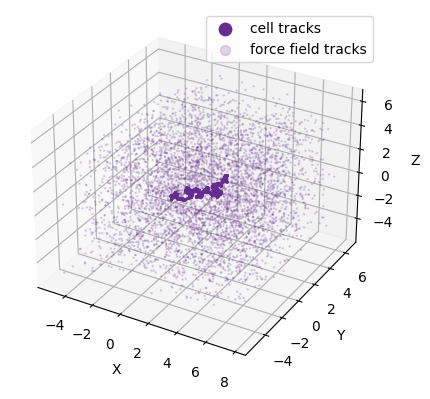

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression
import os

directory = "C:\\tmp\\differential_motion\\"
os.chdir(directory)


with open(f"20230814_motion_uni5f500\\motion_4_motion_path.json", 'r') as f6:
    tracks1 = json.load(f6)

data_merged = [tracks1]

color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']

# Define the legend labels
legend_labels = [r'$[-0.1; 0.1]$', r'$[-0.3; 0.3]$', r'$[-0.5; 0.5]$', r'$[-1; 1]$']

# Plot each track on a new figure
for idx, tracks in enumerate(data_merged):

    # Extract the tracks from the dictionary
    track1_cell = np.array(tracks["cell_A1"])[:5000]
    track1_force = np.array(tracks["motion_cell_A1"])[:5000]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color = color_palette[idx % len(color_palette)]

    # Plot track1 in blue
    p1 = ax.scatter(track1_cell[:, 0], track1_cell[:, 1], track1_cell[:, 2], marker = 'o', c=color, s=0.8, label='cell tracks')
    # Plot track2 in red
    p2 = ax.scatter(track1_force[:, 0], track1_force[:, 1], track1_force[:, 2], marker = 'o', c=color, alpha = 0.2, s=0.5, label='force field tracks')

    # Set labels and title
    ax.set_xlabel('X')
    #ax.set_xlim(-20,-2)
    ax.set_ylabel('Y')
    #ax.set_ylim(-1,20)
    ax.set_zlabel('Z')
    #ax.set_zlim(-20,-5)

    if idx == 0: 
        # Add a legend
        ax.legend(handles=[p1, p2], labels=['cell tracks', 'force field tracks'], markerscale=10)

    # Save the plot to the data folder
    plt.savefig(f"_tracks_seed100_uni_{idx}.png", transparent=True, dpi=500)


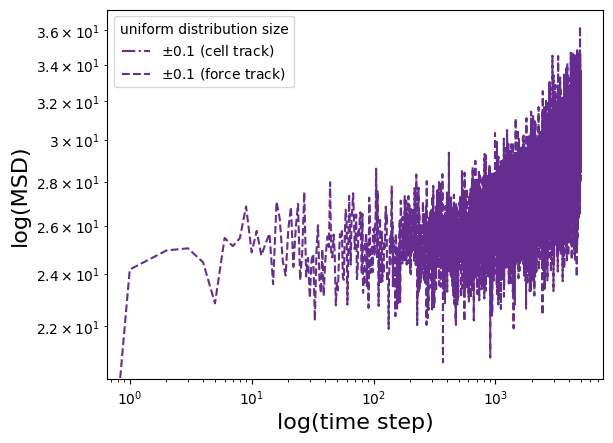

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import os

# Color and line style palettes
color_palette = ['#662D91', '#006838', '#BE1E2D', '#AE7E8E']
line_style_palette = ['-.', '--']

# Define the distribution sizes
distribution_sizes = [r'$\pm$0.1', r'$\pm$0.3', r'$\pm$0.5', r'$\pm$1']

# Create a list to store custom legend entries
legend_entries = []

for idx, msds in enumerate([(mean_squared_displacements_cell1, mean_squared_displacements_force1)]): 
    
    # Get the color for the legend entry
    color = color_palette[idx % len(color_palette)]

    # Create the custom legend entries for cell and force tracks
    legend_entry_cell = Line2D([], [], color=color, linestyle=line_style_palette[0], label=distribution_sizes[idx] + ' (cell track)')
    legend_entry_force = Line2D([], [], color=color, linestyle=line_style_palette[1], label=distribution_sizes[idx] + ' (force track)')

    # Append the legend entries to the list
    legend_entries.append(legend_entry_cell)
    legend_entries.append(legend_entry_force)

    # Plot the mean squared displacements for cell and force with log-log scale
    plt.loglog(msds[0], linestyle=line_style_palette[0], color=color)
    #plt.loglog(msds[1], linestyle=line_style_palette[1], color=color)

# Set the font properties for the legend
legend_font_props = {'family': 'Myriad Pro', 'size': 10}
plt.legend(handles=legend_entries, title=r'uniform distribution size', prop=legend_font_props)

# Set the font properties for the axis labels
axis_label_font_props = {'family': 'Myriad Pro', 'size': 16}
plt.xlabel(r'log(time step)', fontdict=axis_label_font_props)
plt.ylabel(r'log(MSD)', fontdict=axis_label_font_props)

# Save the plot to the data folder
plt.savefig(f"_msd_single_cell_seed1to100.png", transparent=False, dpi=500)
